In [1]:
import numpy as np

import torch
import pickle as pkl
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
use_cuda = False#torch.cuda.is_available()
# device = torch.device('cuda:6') if use_cuda else torch.device('cpu')
from tqdm import tqdm

In [40]:

with open('./data/diffusion_process_1d_pt.pkl','rb') as f:
    data = pkl.load(f)
L = data.shape[-1]
data = torch.tensor(data,dtype=torch.float)
data.shape

torch.Size([50, 200, 100])

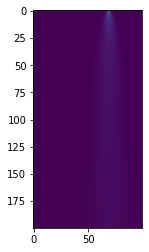

In [41]:
plt.imshow(data[0,:,:])

In [42]:
tgroup = 4#2
sgroup = 2
data.shape
data = data[:,:int((data.shape[1]-1)//tgroup)*tgroup,:int((data.shape[2])//sgroup)*sgroup]
print(data.shape)
data_x = data[:,:-tgroup,:]
data_y = data[:,tgroup:,:]

torch.Size([50, 196, 100])


In [43]:
data_x.shape

torch.Size([50, 192, 100])

In [44]:
batch_size = 16
valid_ratio = 0.2
test_ratio = 0.2
L = data.shape[-1]
cut1 = int((valid_ratio+test_ratio)*data.shape[0])
cut2 =  int(test_ratio*data.shape[0])
print(cut1,cut2)
train_data_x = data_x[:cut1,:,:]
train_data_y = data_y[:cut1,:,:]
valid_data_x = data_x[cut1:cut1+cut2,:,:]
valid_data_y = data_y[cut1:cut1+cut2,:,:]
print(train_data_x.shape,valid_data_x.shape)
# print(dataset1)
dataset1 = torch.utils.data.dataset.TensorDataset(train_data_x, train_data_y)
dataset2 = torch.utils.data.dataset.TensorDataset(valid_data_x, valid_data_y)


train_loader = torch.utils.data.DataLoader(dataset=dataset1,
                                           batch_size=batch_size, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=dataset2,
                                           batch_size=batch_size, 
                                           shuffle=True)


20 10
torch.Size([20, 192, 100]) torch.Size([10, 192, 100])


In [45]:
import torch.nn.functional as F

class NormalizedConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,padding,padding_mode,stride=1):
        super(NormalizedConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, padding_mode=padding_mode, stride=stride,bias=False)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        # normalize weight
        normed_weight = self.softmax(self.conv.weight)
        return F.conv1d(x, normed_weight, self.conv.bias, stride=self.conv.stride,
                        padding=self.conv.padding, dilation=self.conv.dilation)

class Diffusion1D(nn.Module):
    def __init__(self,channel=1):
        super(Diffusion1D, self).__init__()
        kernel = 5
        self.normconv = NormalizedConv1d(1, channel, kernel, padding=1, padding_mode='same')
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.normconv(x.unsqueeze(1))

        x = torch.transpose(x,2,1).squeeze()
        return x

In [46]:
class TemporalSpatialConv(nn.Module):
    def __init__(self, tgroup = 4, sgroup=2):
        super(TemporalSpatialConv, self).__init__()
        self.tgroup = tgroup
        self.sgroup = sgroup
        # 空间卷积
        self.spatial_conv_weight = nn.Parameter(torch.randn(1, 1, sgroup))
        self.temporal_conv_weight = nn.Parameter(torch.randn(1, 1, tgroup))

        self.spatial_deconv_weight = nn.Parameter(torch.randn(1, 1, sgroup))
        self.temporal_deconv_weight = nn.Parameter(torch.randn(1, 1, tgroup))

        
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        return x
    def Encoder(self, x):

        spatial_conv_weight_normalized = F.softmax(self.spatial_conv_weight, dim=-1)
        temporal_conv_weight_normalized = F.softmax(self.temporal_conv_weight,dim=-1)*self.sgroup

        b,t,l = x.shape
        x = x.reshape(-1,1,l)
        
        x = F.conv1d(x, spatial_conv_weight_normalized, stride=self.sgroup).reshape(b,t,l//self.sgroup)
        x = x.permute(0,2,1)
        x = x.reshape(-1,1,t)
        x = F.conv1d(x, temporal_conv_weight_normalized, stride=self.tgroup).reshape(b,l//self.sgroup,t//self.tgroup)
        x = x.permute(0,2,1)
        return x
    def Decoder(self, x):
        
        spatial_conv_weight_normalized = F.softmax(self.spatial_conv_weight, dim=-1)
        temporal_conv_weight_normalized = F.softmax(self.temporal_conv_weight,dim=-1)

        b,t,l = x.shape
        x = x.reshape(-1,1,l)
        
        x = F.conv_transpose1d(x, spatial_conv_weight_normalized, stride=self.sgroup).reshape(b,t,l*self.sgroup)
        x = x.permute(0,2,1)
        x = x.reshape(-1,1,t)
        x = F.conv_transpose1d(x, temporal_conv_weight_normalized, stride=self.tgroup).reshape(b,l*self.sgroup,t*self.tgroup)
        x = x.permute(0,2,1)

        return x

In [100]:
'load dynamic learner'
seed = 2052
kernel_size=5
# dynamic = torch.load(f'./models/dynamic/diffusion_dynamic_k=5_{seed}.pth')
dynamic = torch.load(f'./models/dynamic/diffusion_dynamic_k={kernel_size}_{seed}.pth')
dynamic.eval()

Diffusion1D(
  (normconv): NormalizedConv1d(
    (conv): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    (softmax): Softmax(dim=-1)
  )
  (relu): ReLU()
)

In [101]:
NEAR_ZERO = 1e-10
tgroup,sgroup

(4, 2)

  0%|                                                                                                                     | 0/10000 [00:00<?, ?it/s]

save
epoch: 0/10000: train loss:2.2493025064468384,valid_loss:2.250685453414917


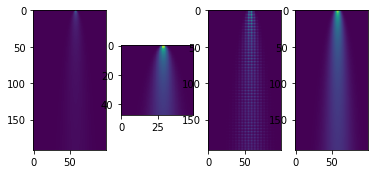

  0%|                                                                                                            | 10/10000 [00:01<19:50,  8.39it/s]

save
epoch: 10/10000: train loss:2.2230905294418335,valid_loss:2.2250356674194336


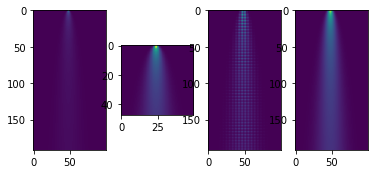

  0%|▏                                                                                                           | 20/10000 [00:02<20:15,  8.21it/s]

save
epoch: 20/10000: train loss:2.198300838470459,valid_loss:2.200011730194092


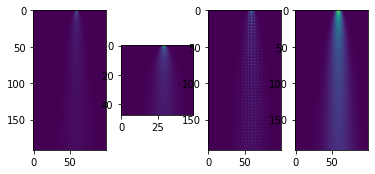

  0%|▎                                                                                                           | 30/10000 [00:04<20:55,  7.94it/s]

save
epoch: 30/10000: train loss:2.1741448640823364,valid_loss:2.175647497177124


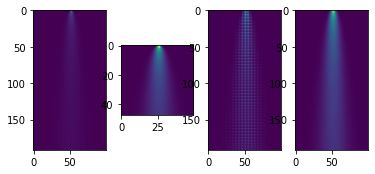

  0%|▍                                                                                                           | 40/10000 [00:05<19:56,  8.32it/s]

save
epoch: 40/10000: train loss:2.1493407487869263,valid_loss:2.151928663253784


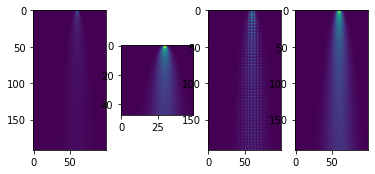

  0%|▌                                                                                                           | 50/10000 [00:07<20:27,  8.11it/s]

save
epoch: 50/10000: train loss:2.126897096633911,valid_loss:2.128819227218628


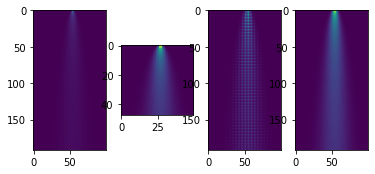

  1%|▋                                                                                                           | 60/10000 [00:08<20:29,  8.09it/s]

save
epoch: 60/10000: train loss:2.105337381362915,valid_loss:2.106285572052002


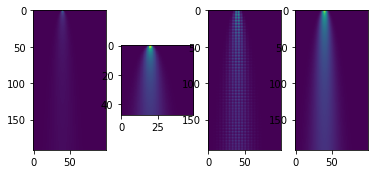

  1%|▊                                                                                                           | 70/10000 [00:10<19:24,  8.53it/s]

save
epoch: 70/10000: train loss:2.0814735889434814,valid_loss:2.0842955112457275


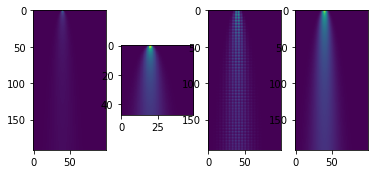

  1%|▊                                                                                                           | 80/10000 [00:11<19:04,  8.67it/s]

save
epoch: 80/10000: train loss:2.060562014579773,valid_loss:2.0628228187561035


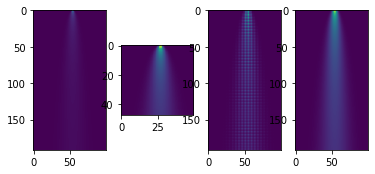

  1%|▉                                                                                                           | 90/10000 [00:12<19:09,  8.62it/s]

save
epoch: 90/10000: train loss:2.039001703262329,valid_loss:2.041844129562378


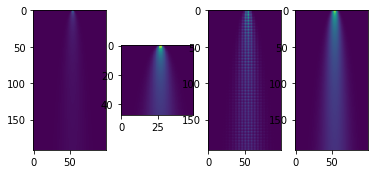

  1%|█                                                                                                          | 100/10000 [00:14<20:27,  8.06it/s]

save
epoch: 100/10000: train loss:2.0193296670913696,valid_loss:2.0213396549224854


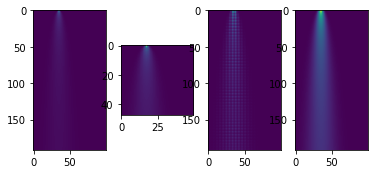

  1%|█▏                                                                                                         | 110/10000 [00:15<19:15,  8.56it/s]

save
epoch: 110/10000: train loss:1.9998252391815186,valid_loss:2.0012917518615723


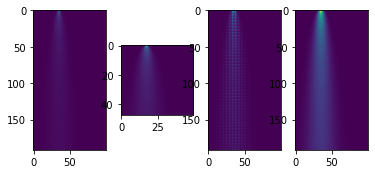

  1%|█▎                                                                                                         | 119/10000 [00:17<19:06,  8.62it/s]

save
epoch: 120/10000: train loss:1.9787951707839966,valid_loss:1.9816826581954956


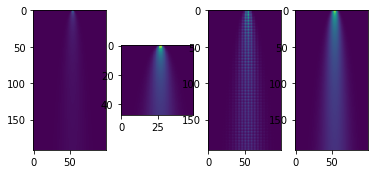

  1%|█▍                                                                                                         | 130/10000 [00:18<20:29,  8.03it/s]

save
epoch: 130/10000: train loss:1.9597328305244446,valid_loss:1.96250319480896


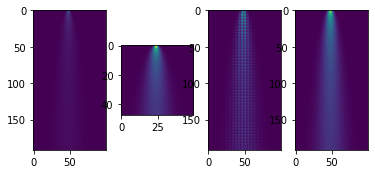

  1%|█▍                                                                                                         | 140/10000 [00:19<19:18,  8.51it/s]

save
epoch: 140/10000: train loss:1.942734956741333,valid_loss:1.9437406063079834


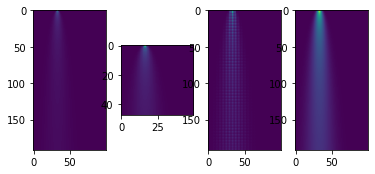

  2%|█▌                                                                                                         | 150/10000 [00:21<19:05,  8.60it/s]

save
epoch: 150/10000: train loss:1.9242691397666931,valid_loss:1.9253780841827393


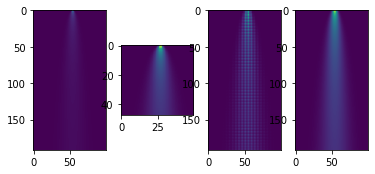

  2%|█▋                                                                                                         | 160/10000 [00:22<18:32,  8.85it/s]

save
epoch: 160/10000: train loss:1.9053069353103638,valid_loss:1.9074159860610962


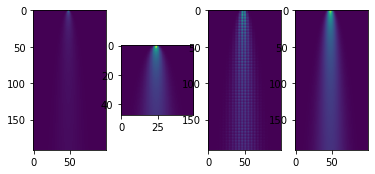

  2%|█▊                                                                                                         | 170/10000 [00:24<20:40,  7.92it/s]

save
epoch: 170/10000: train loss:1.8882983922958374,valid_loss:1.889848232269287


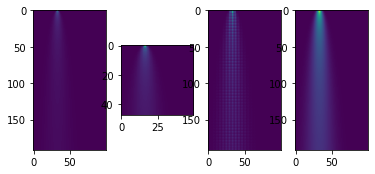

  2%|█▉                                                                                                         | 180/10000 [00:25<20:26,  8.00it/s]

save
epoch: 180/10000: train loss:1.8701227903366089,valid_loss:1.8726634979248047


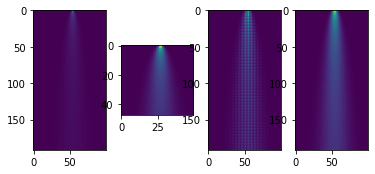

  2%|██                                                                                                         | 190/10000 [00:26<18:49,  8.69it/s]

save
epoch: 190/10000: train loss:1.8531659841537476,valid_loss:1.85585618019104


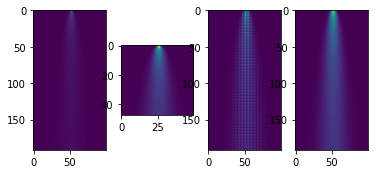

  2%|██▏                                                                                                        | 200/10000 [00:28<19:16,  8.47it/s]

save
epoch: 200/10000: train loss:1.83603173494339,valid_loss:1.8394266366958618


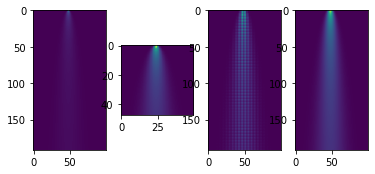

  2%|██▏                                                                                                        | 210/10000 [00:29<20:11,  8.08it/s]

save
epoch: 210/10000: train loss:1.8205576539039612,valid_loss:1.8233658075332642


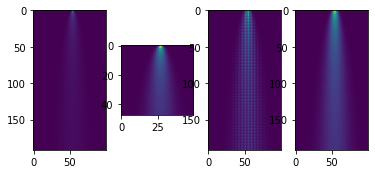

  2%|██▎                                                                                                        | 220/10000 [00:31<19:05,  8.53it/s]

save
epoch: 220/10000: train loss:1.805848479270935,valid_loss:1.807679295539856


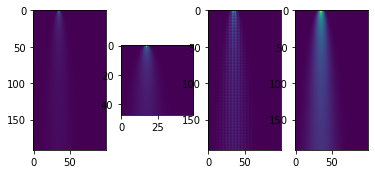

  2%|██▍                                                                                                        | 230/10000 [00:32<18:28,  8.82it/s]

save
epoch: 230/10000: train loss:1.790134072303772,valid_loss:1.7923539876937866


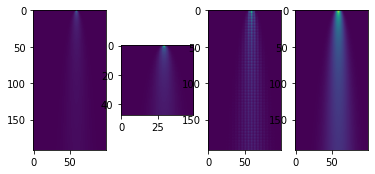

  2%|██▌                                                                                                        | 240/10000 [00:33<18:35,  8.75it/s]

save
epoch: 240/10000: train loss:1.7758175134658813,valid_loss:1.7773929834365845


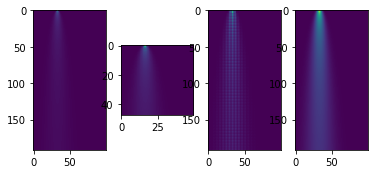

  2%|██▋                                                                                                        | 250/10000 [00:35<20:03,  8.10it/s]

save
epoch: 250/10000: train loss:1.761964499950409,valid_loss:1.7627934217453003


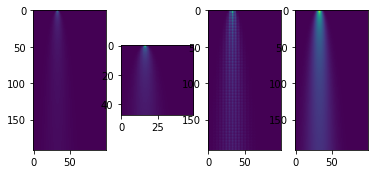

  3%|██▊                                                                                                        | 260/10000 [00:36<18:49,  8.62it/s]

save
epoch: 260/10000: train loss:1.7478655576705933,valid_loss:1.7485586404800415


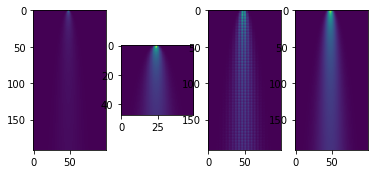

  3%|██▉                                                                                                        | 270/10000 [00:37<18:31,  8.75it/s]

save
epoch: 270/10000: train loss:1.7333436608314514,valid_loss:1.7346800565719604


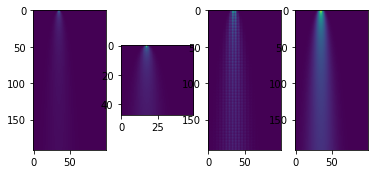

  3%|██▉                                                                                                        | 280/10000 [00:39<20:19,  7.97it/s]

save
epoch: 280/10000: train loss:1.7204195857048035,valid_loss:1.7211586236953735


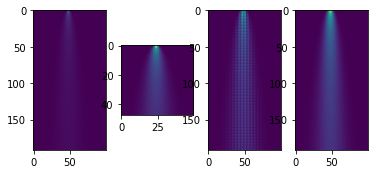

  3%|███                                                                                                        | 290/10000 [00:40<19:01,  8.50it/s]

save
epoch: 290/10000: train loss:1.7065448760986328,valid_loss:1.7079867124557495


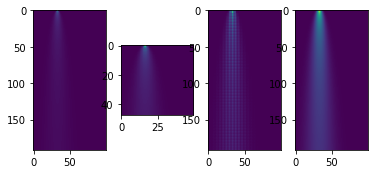

  3%|███▏                                                                                                       | 300/10000 [00:42<18:35,  8.70it/s]

save
epoch: 300/10000: train loss:1.6938222646713257,valid_loss:1.6951730251312256


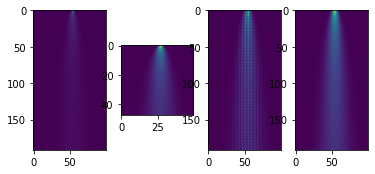

  3%|███▎                                                                                                       | 310/10000 [00:43<20:57,  7.71it/s]

save
epoch: 310/10000: train loss:1.681258738040924,valid_loss:1.6827056407928467


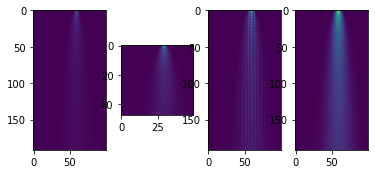

  3%|███▍                                                                                                       | 320/10000 [00:44<19:50,  8.13it/s]

save
epoch: 320/10000: train loss:1.668910026550293,valid_loss:1.6705849170684814


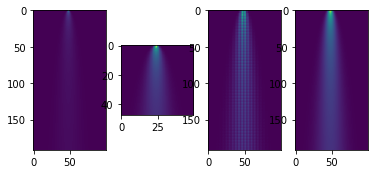

  3%|███▌                                                                                                       | 330/10000 [00:46<18:50,  8.55it/s]

save
epoch: 330/10000: train loss:1.6575304865837097,valid_loss:1.6588033437728882


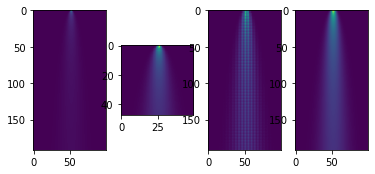

  3%|███▋                                                                                                       | 339/10000 [00:47<18:30,  8.70it/s]

save
epoch: 340/10000: train loss:1.646036148071289,valid_loss:1.6473652124404907


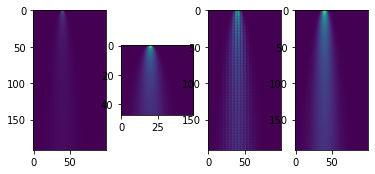

  4%|███▋                                                                                                       | 350/10000 [00:49<19:54,  8.08it/s]

save
epoch: 350/10000: train loss:1.6346819996833801,valid_loss:1.6362611055374146


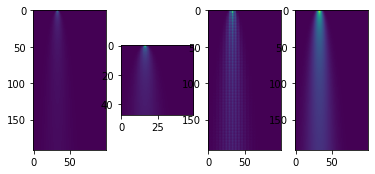

  4%|███▊                                                                                                       | 360/10000 [00:50<19:18,  8.32it/s]

save
epoch: 360/10000: train loss:1.624192476272583,valid_loss:1.6254889965057373


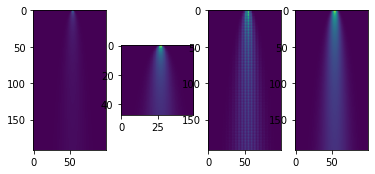

  4%|███▉                                                                                                       | 370/10000 [00:51<18:33,  8.65it/s]

save
epoch: 370/10000: train loss:1.6131772994995117,valid_loss:1.6150476932525635


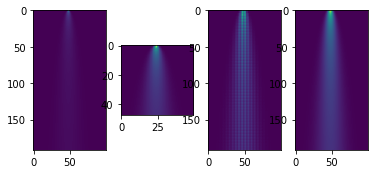

  4%|████                                                                                                       | 380/10000 [00:53<18:43,  8.56it/s]

save
epoch: 380/10000: train loss:1.6037920117378235,valid_loss:1.604929804801941


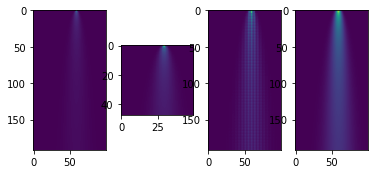

  4%|████▏                                                                                                      | 390/10000 [00:54<20:05,  7.97it/s]

save
epoch: 390/10000: train loss:1.593305230140686,valid_loss:1.5951370000839233


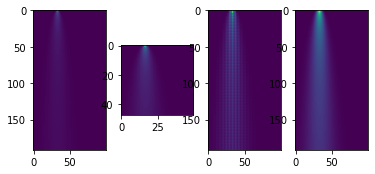

  4%|████▎                                                                                                      | 400/10000 [00:56<18:39,  8.58it/s]

save
epoch: 400/10000: train loss:1.583328902721405,valid_loss:1.5856647491455078


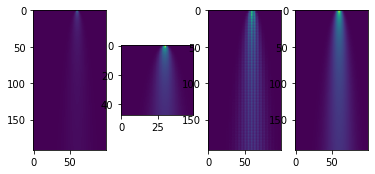

  4%|████▍                                                                                                      | 409/10000 [00:57<18:20,  8.71it/s]

save
epoch: 410/10000: train loss:1.5753386616706848,valid_loss:1.5765029191970825


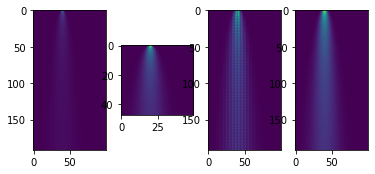

  4%|████▍                                                                                                      | 420/10000 [00:58<20:06,  7.94it/s]

save
epoch: 420/10000: train loss:1.567064106464386,valid_loss:1.5676484107971191


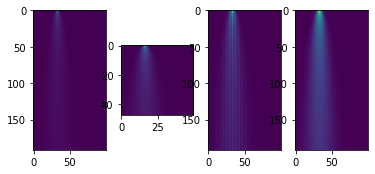

  4%|████▌                                                                                                      | 430/10000 [01:00<19:14,  8.29it/s]

save
epoch: 430/10000: train loss:1.5570568442344666,valid_loss:1.5591005086898804


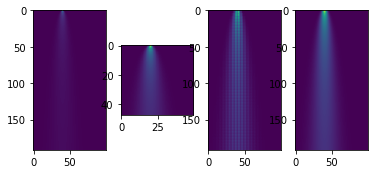

  4%|████▋                                                                                                      | 440/10000 [01:01<18:28,  8.63it/s]

save
epoch: 440/10000: train loss:1.5484833717346191,valid_loss:1.5508509874343872


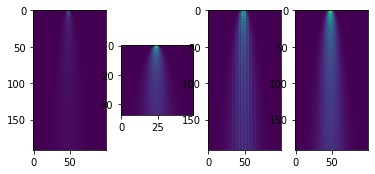

  4%|████▊                                                                                                      | 450/10000 [01:02<18:32,  8.59it/s]

save
epoch: 450/10000: train loss:1.540870726108551,valid_loss:1.5428950786590576


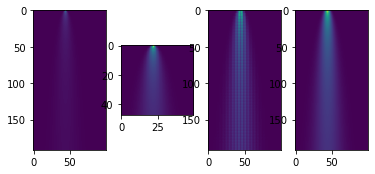

  5%|████▉                                                                                                      | 460/10000 [01:04<20:19,  7.82it/s]

save
epoch: 460/10000: train loss:1.5338565707206726,valid_loss:1.5352320671081543


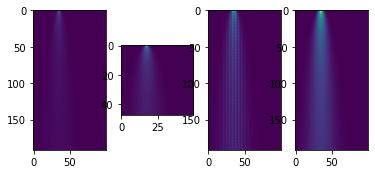

  5%|█████                                                                                                      | 470/10000 [01:05<18:36,  8.54it/s]

save
epoch: 470/10000: train loss:1.5258435606956482,valid_loss:1.5278528928756714


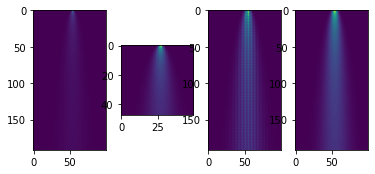

  5%|█████▏                                                                                                     | 480/10000 [01:07<21:29,  7.38it/s]

save
epoch: 480/10000: train loss:1.5186861753463745,valid_loss:1.5207515954971313


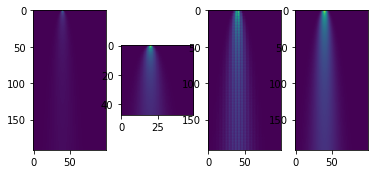

  5%|█████▏                                                                                                     | 490/10000 [01:08<18:36,  8.52it/s]

save
epoch: 490/10000: train loss:1.5122833251953125,valid_loss:1.513921856880188


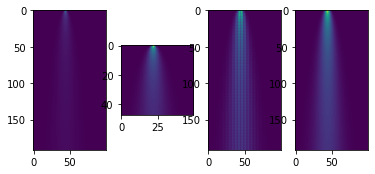

  5%|█████▎                                                                                                     | 500/10000 [01:10<19:19,  8.19it/s]

save
epoch: 500/10000: train loss:1.5056655406951904,valid_loss:1.5073585510253906


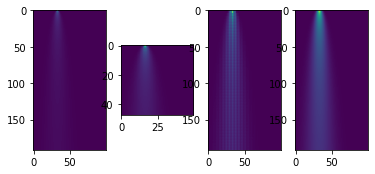

  5%|█████▍                                                                                                     | 510/10000 [01:11<18:51,  8.39it/s]

save
epoch: 510/10000: train loss:1.4995536804199219,valid_loss:1.501062035560608


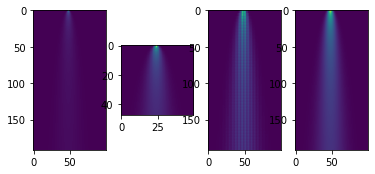

  5%|█████▌                                                                                                     | 520/10000 [01:12<18:11,  8.69it/s]

save
epoch: 520/10000: train loss:1.493976652622223,valid_loss:1.4950214624404907


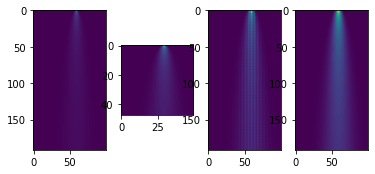

  5%|█████▋                                                                                                     | 530/10000 [01:14<18:28,  8.54it/s]

save
epoch: 530/10000: train loss:1.487295150756836,valid_loss:1.4892209768295288


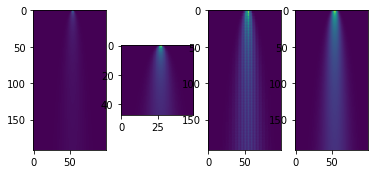

  5%|█████▊                                                                                                     | 540/10000 [01:15<19:14,  8.20it/s]

save
epoch: 540/10000: train loss:1.481361746788025,valid_loss:1.4836708307266235


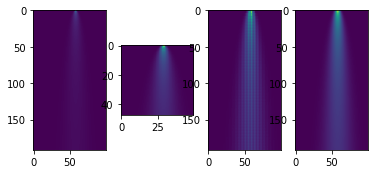

  6%|█████▉                                                                                                     | 550/10000 [01:17<18:15,  8.62it/s]

save
epoch: 550/10000: train loss:1.4768640995025635,valid_loss:1.4783618450164795


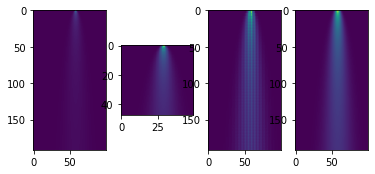

  6%|█████▉                                                                                                     | 560/10000 [01:18<18:00,  8.74it/s]

save
epoch: 560/10000: train loss:1.4722990989685059,valid_loss:1.4732838869094849


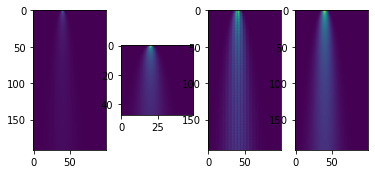

  6%|██████                                                                                                     | 570/10000 [01:19<19:39,  7.99it/s]

save
epoch: 570/10000: train loss:1.4675368666648865,valid_loss:1.4684244394302368


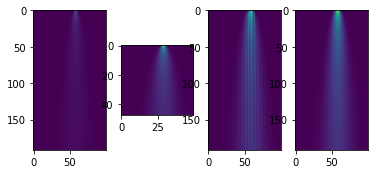

  6%|██████▏                                                                                                    | 580/10000 [01:21<19:28,  8.06it/s]

save
epoch: 580/10000: train loss:1.4619107246398926,valid_loss:1.4637895822525024


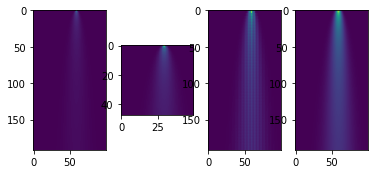

  6%|██████▎                                                                                                    | 590/10000 [01:22<18:20,  8.55it/s]

save
epoch: 590/10000: train loss:1.4580346941947937,valid_loss:1.459373950958252


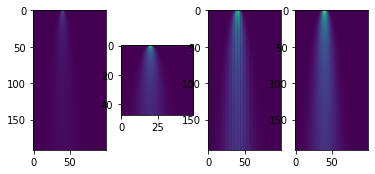

  6%|██████▍                                                                                                    | 600/10000 [01:24<19:31,  8.02it/s]

save
epoch: 600/10000: train loss:1.4534021019935608,valid_loss:1.4551622867584229


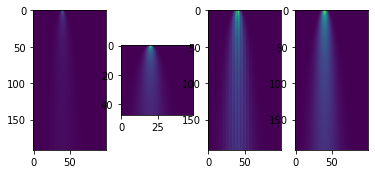

  6%|██████▌                                                                                                    | 610/10000 [01:25<20:47,  7.53it/s]

save
epoch: 610/10000: train loss:1.450266182422638,valid_loss:1.4511510133743286


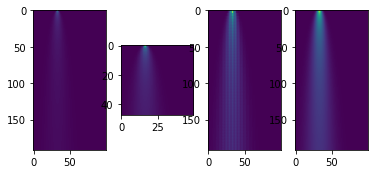

  6%|██████▋                                                                                                    | 620/10000 [01:27<18:53,  8.28it/s]

save
epoch: 620/10000: train loss:1.4460753798484802,valid_loss:1.4473340511322021


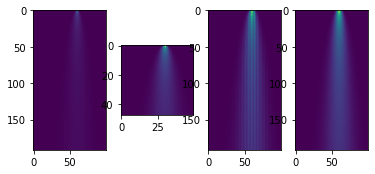

  6%|██████▋                                                                                                    | 630/10000 [01:28<17:38,  8.85it/s]

save
epoch: 630/10000: train loss:1.4428818225860596,valid_loss:1.4437072277069092


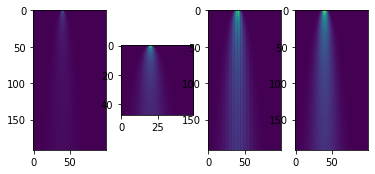

  6%|██████▊                                                                                                    | 639/10000 [01:29<17:44,  8.79it/s]

save
epoch: 640/10000: train loss:1.4389697909355164,valid_loss:1.4402611255645752


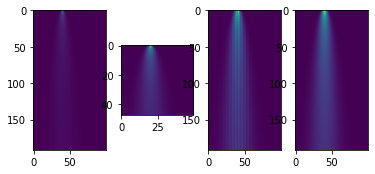

  6%|██████▉                                                                                                    | 650/10000 [01:31<20:23,  7.64it/s]

save
epoch: 650/10000: train loss:1.4352807402610779,valid_loss:1.436989426612854


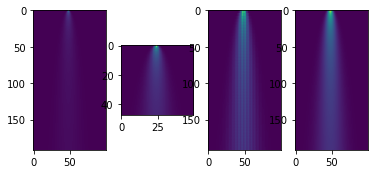

  7%|███████                                                                                                    | 660/10000 [01:32<18:19,  8.49it/s]

save
epoch: 660/10000: train loss:1.4329586029052734,valid_loss:1.4338877201080322


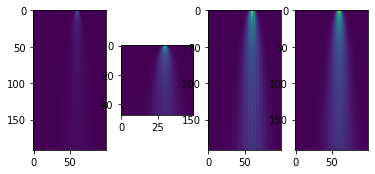

  7%|███████▏                                                                                                   | 670/10000 [01:34<17:59,  8.65it/s]

save
epoch: 670/10000: train loss:1.4299583435058594,valid_loss:1.4309502840042114


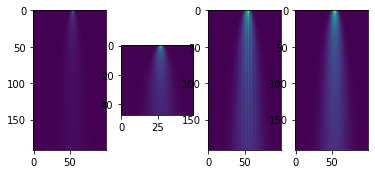

  7%|███████▎                                                                                                   | 680/10000 [01:35<24:29,  6.34it/s]

save
epoch: 680/10000: train loss:1.426773488521576,valid_loss:1.4281708002090454


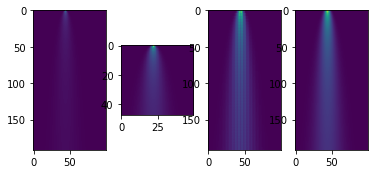

  7%|███████▍                                                                                                   | 690/10000 [01:37<18:58,  8.18it/s]

save
epoch: 690/10000: train loss:1.4246370196342468,valid_loss:1.425543189048767


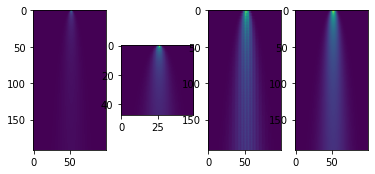

  7%|███████▍                                                                                                   | 700/10000 [01:38<18:07,  8.55it/s]

save
epoch: 700/10000: train loss:1.4219685792922974,valid_loss:1.4230550527572632


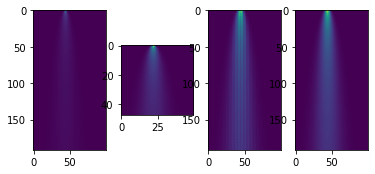

  7%|███████▌                                                                                                   | 709/10000 [01:39<18:00,  8.60it/s]

save
epoch: 710/10000: train loss:1.4191116690635681,valid_loss:1.4207122325897217


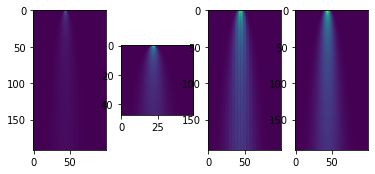

  7%|███████▋                                                                                                   | 720/10000 [01:41<20:31,  7.53it/s]

save
epoch: 720/10000: train loss:1.4177034497261047,valid_loss:1.4185028076171875


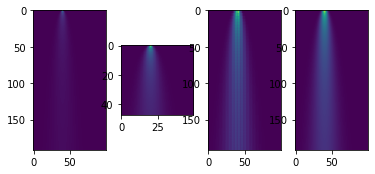

  7%|███████▊                                                                                                   | 730/10000 [01:42<18:33,  8.33it/s]

save
epoch: 730/10000: train loss:1.415638506412506,valid_loss:1.4164221286773682


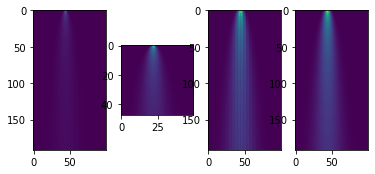

  7%|███████▉                                                                                                   | 740/10000 [01:43<18:04,  8.54it/s]

save
epoch: 740/10000: train loss:1.4134366512298584,valid_loss:1.4144656658172607


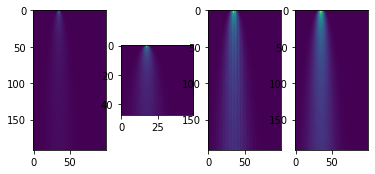

  8%|████████                                                                                                   | 750/10000 [01:45<18:32,  8.31it/s]

save
epoch: 750/10000: train loss:1.411787748336792,valid_loss:1.4126232862472534


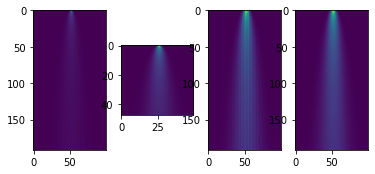

  8%|████████▏                                                                                                  | 760/10000 [01:46<18:49,  8.18it/s]

save
epoch: 760/10000: train loss:1.4095860123634338,valid_loss:1.4108970165252686


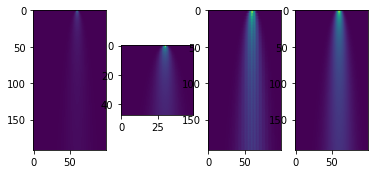

  8%|████████▏                                                                                                  | 770/10000 [01:48<18:23,  8.37it/s]

save
epoch: 770/10000: train loss:1.408639669418335,valid_loss:1.4092755317687988


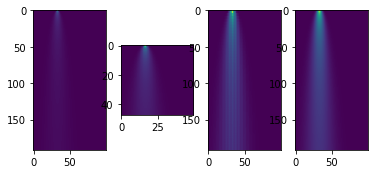

  8%|████████▎                                                                                                  | 780/10000 [01:49<17:26,  8.81it/s]

save
epoch: 780/10000: train loss:1.4066379070281982,valid_loss:1.4077544212341309


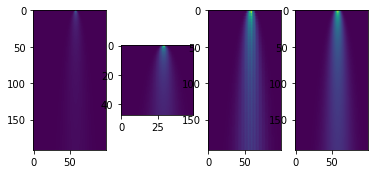

  8%|████████▍                                                                                                  | 790/10000 [01:50<19:11,  8.00it/s]

save
epoch: 790/10000: train loss:1.4056804776191711,valid_loss:1.4063323736190796


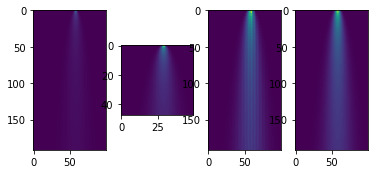

  8%|████████▌                                                                                                  | 800/10000 [01:52<18:48,  8.15it/s]

save
epoch: 800/10000: train loss:1.4042417407035828,valid_loss:1.405002236366272


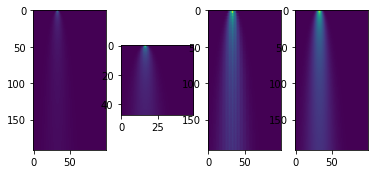

  8%|████████▋                                                                                                  | 810/10000 [01:53<17:56,  8.54it/s]

save
epoch: 810/10000: train loss:1.4028926491737366,valid_loss:1.403760552406311


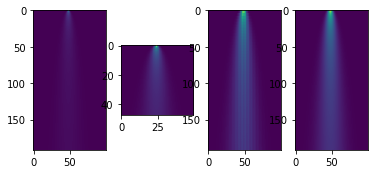

  8%|████████▊                                                                                                  | 820/10000 [01:55<17:22,  8.81it/s]

save
epoch: 820/10000: train loss:1.4017539024353027,valid_loss:1.40259850025177


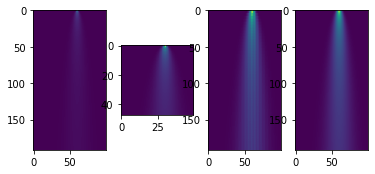

  8%|████████▉                                                                                                  | 830/10000 [01:56<19:01,  8.03it/s]

save
epoch: 830/10000: train loss:1.4000867009162903,valid_loss:1.401513934135437


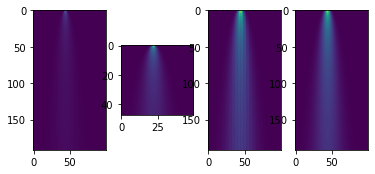

  8%|████████▉                                                                                                  | 840/10000 [01:57<18:05,  8.44it/s]

save
epoch: 840/10000: train loss:1.3994141817092896,valid_loss:1.4005062580108643


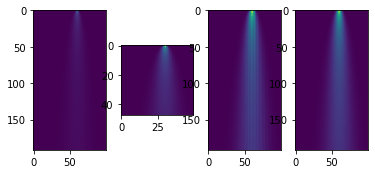

  8%|█████████                                                                                                  | 850/10000 [01:59<17:50,  8.55it/s]

save
epoch: 850/10000: train loss:1.3984228372573853,valid_loss:1.3995684385299683


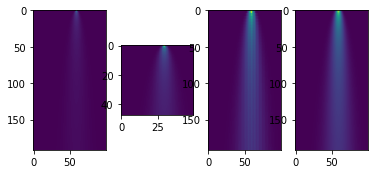

  9%|█████████▏                                                                                                 | 860/10000 [02:00<17:05,  8.91it/s]

save
epoch: 860/10000: train loss:1.398033320903778,valid_loss:1.398694634437561


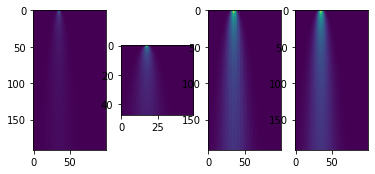

  9%|█████████▎                                                                                                 | 870/10000 [02:01<19:11,  7.93it/s]

save
epoch: 870/10000: train loss:1.3971968293190002,valid_loss:1.3978816270828247


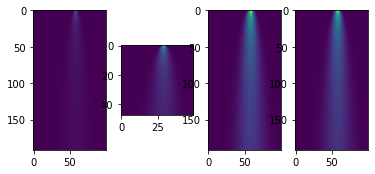

  9%|█████████▍                                                                                                 | 880/10000 [02:03<17:46,  8.55it/s]

save
epoch: 880/10000: train loss:1.3963213562965393,valid_loss:1.397128939628601


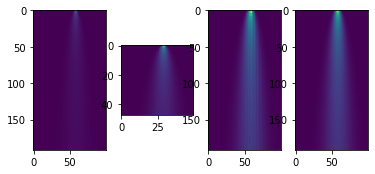

  9%|█████████▌                                                                                                 | 890/10000 [02:04<17:22,  8.74it/s]

save
epoch: 890/10000: train loss:1.3951886892318726,valid_loss:1.3964308500289917


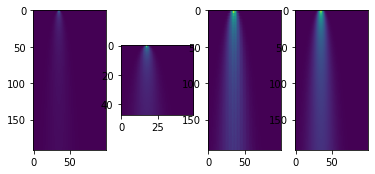

  9%|█████████▋                                                                                                 | 900/10000 [02:06<17:44,  8.55it/s]

save
epoch: 900/10000: train loss:1.3950077295303345,valid_loss:1.3957855701446533


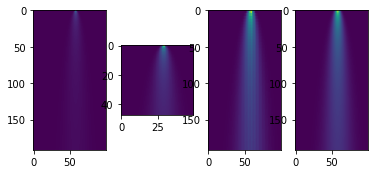

  9%|█████████▋                                                                                                 | 910/10000 [02:07<21:10,  7.15it/s]

save
epoch: 910/10000: train loss:1.3942696452140808,valid_loss:1.395189642906189


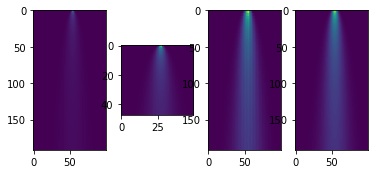

  9%|█████████▊                                                                                                 | 920/10000 [02:09<17:42,  8.55it/s]

save
epoch: 920/10000: train loss:1.3938696384429932,valid_loss:1.3946387767791748


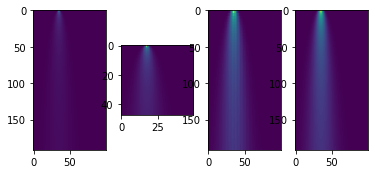

  9%|█████████▉                                                                                                 | 930/10000 [02:10<17:17,  8.74it/s]

save
epoch: 930/10000: train loss:1.3938092589378357,valid_loss:1.3941307067871094


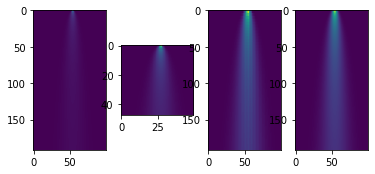

  9%|██████████                                                                                                 | 940/10000 [02:11<17:43,  8.52it/s]

save
epoch: 940/10000: train loss:1.3925116062164307,valid_loss:1.3936606645584106


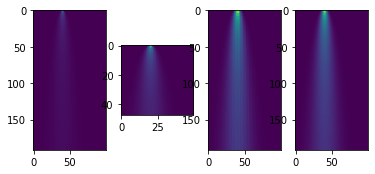

 10%|██████████▏                                                                                                | 950/10000 [02:13<18:27,  8.17it/s]

save
epoch: 950/10000: train loss:1.3925257921218872,valid_loss:1.3932299613952637


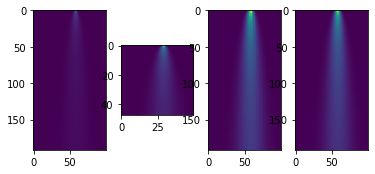

 10%|██████████▎                                                                                                | 960/10000 [02:14<17:33,  8.58it/s]

save
epoch: 960/10000: train loss:1.3917762637138367,valid_loss:1.3928320407867432


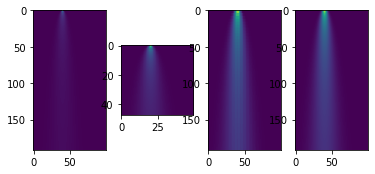

 10%|██████████▍                                                                                                | 970/10000 [02:16<17:48,  8.45it/s]

save
epoch: 970/10000: train loss:1.3919458985328674,valid_loss:1.3924678564071655


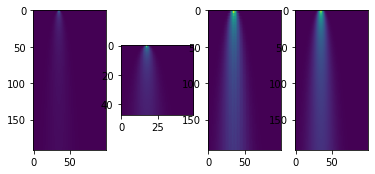

 10%|██████████▍                                                                                                | 980/10000 [02:17<19:13,  7.82it/s]

save
epoch: 980/10000: train loss:1.391030728816986,valid_loss:1.3921326398849487


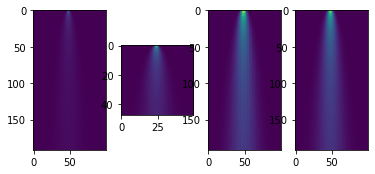

 10%|██████████▌                                                                                                | 990/10000 [02:19<17:46,  8.45it/s]

save
epoch: 990/10000: train loss:1.391301155090332,valid_loss:1.3918259143829346


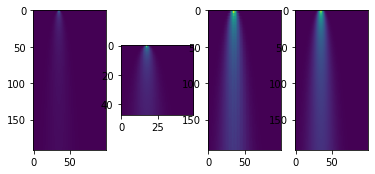

 10%|██████████▌                                                                                               | 1000/10000 [02:20<17:21,  8.64it/s]

save
epoch: 1000/10000: train loss:1.3910948038101196,valid_loss:1.3915444612503052


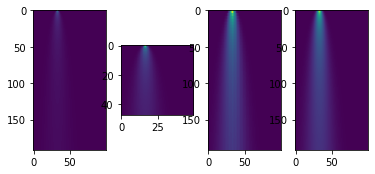

 10%|██████████▋                                                                                               | 1010/10000 [02:21<18:22,  8.15it/s]

save
epoch: 1010/10000: train loss:1.3902366757392883,valid_loss:1.3912867307662964


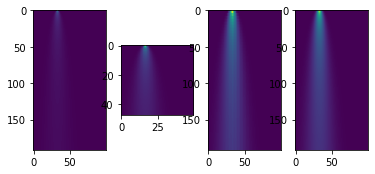

 10%|██████████▊                                                                                               | 1020/10000 [02:23<19:01,  7.87it/s]

save
epoch: 1020/10000: train loss:1.390311598777771,valid_loss:1.3910508155822754


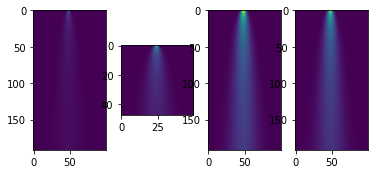

 10%|██████████▉                                                                                               | 1030/10000 [02:24<17:38,  8.47it/s]

save
epoch: 1030/10000: train loss:1.3899343013763428,valid_loss:1.3908352851867676


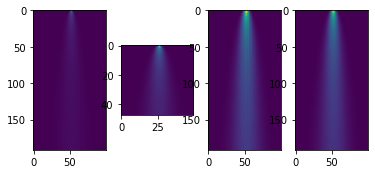

 10%|███████████                                                                                               | 1040/10000 [02:25<16:56,  8.82it/s]

save
epoch: 1040/10000: train loss:1.3903021216392517,valid_loss:1.390640139579773


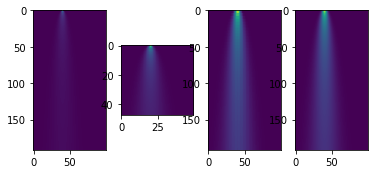

 10%|███████████▏                                                                                              | 1050/10000 [02:27<17:25,  8.56it/s]

save
epoch: 1050/10000: train loss:1.3897878527641296,valid_loss:1.3904623985290527


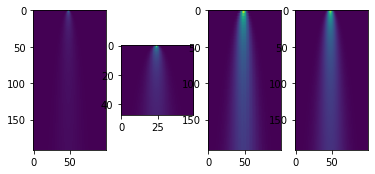

 11%|███████████▏                                                                                              | 1060/10000 [02:28<18:19,  8.13it/s]

save
epoch: 1060/10000: train loss:1.389596700668335,valid_loss:1.390300989151001


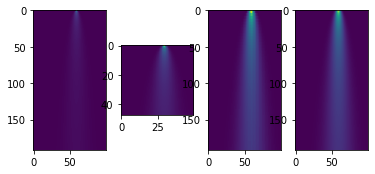

 11%|███████████▎                                                                                              | 1070/10000 [02:30<17:27,  8.53it/s]

save
epoch: 1070/10000: train loss:1.389666497707367,valid_loss:1.3901537656784058


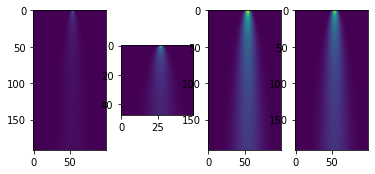

 11%|███████████▍                                                                                              | 1080/10000 [02:31<16:53,  8.80it/s]

save
epoch: 1080/10000: train loss:1.389452040195465,valid_loss:1.3900202512741089


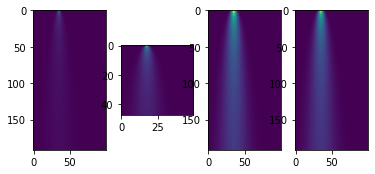

 11%|███████████▌                                                                                              | 1090/10000 [02:32<17:35,  8.44it/s]

save
epoch: 1090/10000: train loss:1.3892648220062256,valid_loss:1.3898988962173462


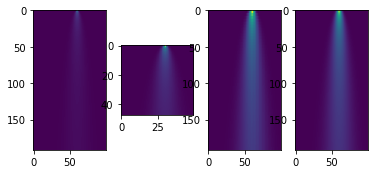

 11%|███████████▋                                                                                              | 1100/10000 [02:34<18:22,  8.07it/s]

save
epoch: 1100/10000: train loss:1.389495074748993,valid_loss:1.3897898197174072


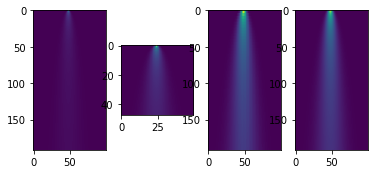

 11%|███████████▊                                                                                              | 1110/10000 [02:35<17:31,  8.45it/s]

save
epoch: 1110/10000: train loss:1.3889920711517334,valid_loss:1.38969087600708


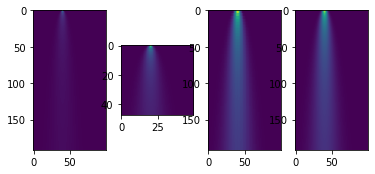

 11%|███████████▊                                                                                              | 1120/10000 [02:37<16:56,  8.73it/s]

save
epoch: 1120/10000: train loss:1.388795256614685,valid_loss:1.389601230621338


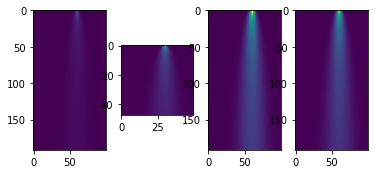

 11%|███████████▉                                                                                              | 1130/10000 [02:38<17:48,  8.30it/s]

save
epoch: 1130/10000: train loss:1.3892387747764587,valid_loss:1.389520287513733


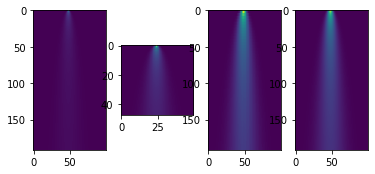

 11%|████████████                                                                                              | 1140/10000 [02:39<17:57,  8.23it/s]

save
epoch: 1140/10000: train loss:1.3889760375022888,valid_loss:1.389447808265686


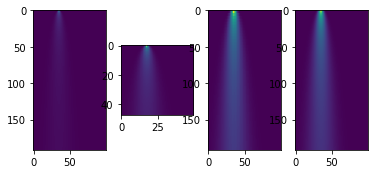

 12%|████████████▏                                                                                             | 1150/10000 [02:41<17:04,  8.64it/s]

save
epoch: 1150/10000: train loss:1.3887803554534912,valid_loss:1.3893829584121704


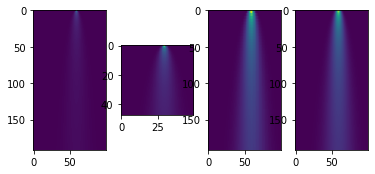

 12%|████████████▎                                                                                             | 1160/10000 [02:42<16:23,  8.99it/s]

save
epoch: 1160/10000: train loss:1.388893485069275,valid_loss:1.389323115348816


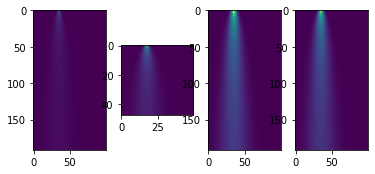

 12%|████████████▍                                                                                             | 1170/10000 [02:43<18:05,  8.13it/s]

save
epoch: 1170/10000: train loss:1.388532817363739,valid_loss:1.3892695903778076


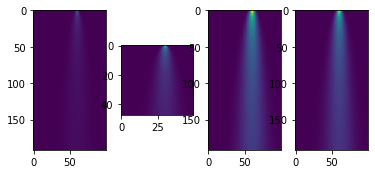

 12%|████████████▌                                                                                             | 1180/10000 [02:45<17:31,  8.39it/s]

save
epoch: 1180/10000: train loss:1.3889389634132385,valid_loss:1.389220952987671


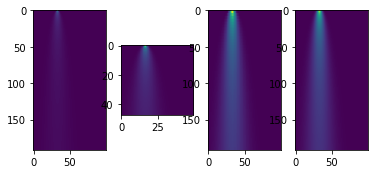

 12%|████████████▌                                                                                             | 1190/10000 [02:46<16:37,  8.83it/s]

save
epoch: 1190/10000: train loss:1.388655185699463,valid_loss:1.3891774415969849


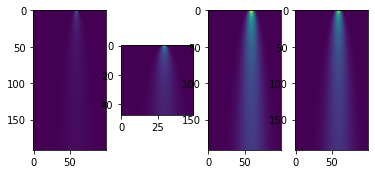

 12%|████████████▋                                                                                             | 1200/10000 [02:48<17:45,  8.26it/s]

save
epoch: 1200/10000: train loss:1.3888627290725708,valid_loss:1.3891386985778809


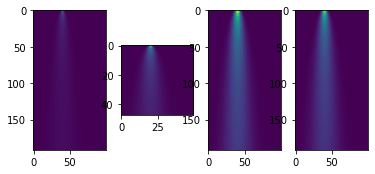

 12%|████████████▊                                                                                             | 1210/10000 [02:49<18:13,  8.04it/s]

save
epoch: 1210/10000: train loss:1.3888509273529053,valid_loss:1.389103651046753


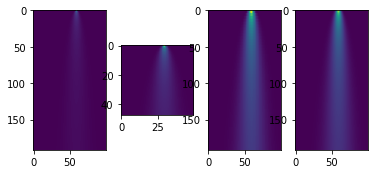

 12%|████████████▉                                                                                             | 1220/10000 [02:50<17:25,  8.40it/s]

save
epoch: 1220/10000: train loss:1.388662576675415,valid_loss:1.3890726566314697


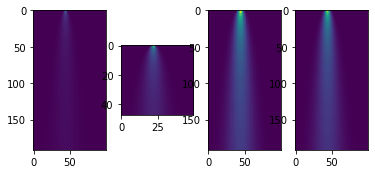

 12%|█████████████                                                                                             | 1230/10000 [02:52<16:46,  8.71it/s]

save
epoch: 1230/10000: train loss:1.388655424118042,valid_loss:1.3890454769134521


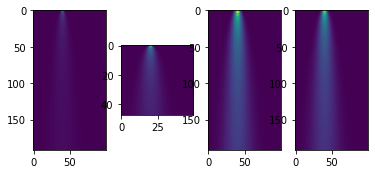

 12%|█████████████▏                                                                                            | 1240/10000 [02:53<19:57,  7.31it/s]

save
epoch: 1240/10000: train loss:1.3884735703468323,valid_loss:1.3890208005905151


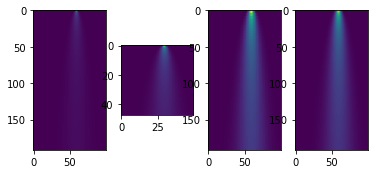

 12%|█████████████▎                                                                                            | 1250/10000 [02:55<17:46,  8.20it/s]

save
epoch: 1250/10000: train loss:1.388274610042572,valid_loss:1.388999342918396


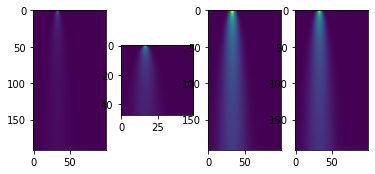

 13%|█████████████▎                                                                                            | 1260/10000 [02:56<16:58,  8.58it/s]

save
epoch: 1260/10000: train loss:1.3887609839439392,valid_loss:1.3889796733856201


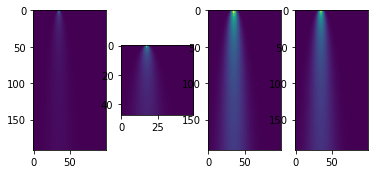

 13%|█████████████▍                                                                                            | 1270/10000 [02:57<17:19,  8.40it/s]

save
epoch: 1270/10000: train loss:1.3885645270347595,valid_loss:1.3889622688293457


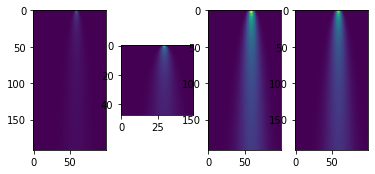

 13%|█████████████▌                                                                                            | 1280/10000 [02:59<18:25,  7.89it/s]

save
epoch: 1280/10000: train loss:1.3885844945907593,valid_loss:1.3889470100402832


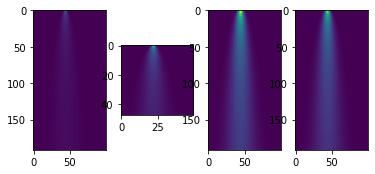

 13%|█████████████▋                                                                                            | 1290/10000 [03:00<17:07,  8.47it/s]

save
epoch: 1290/10000: train loss:1.3886374831199646,valid_loss:1.388933539390564


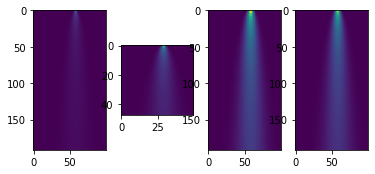

 13%|█████████████▊                                                                                            | 1300/10000 [03:02<16:47,  8.64it/s]

save
epoch: 1300/10000: train loss:1.3887325525283813,valid_loss:1.3889209032058716


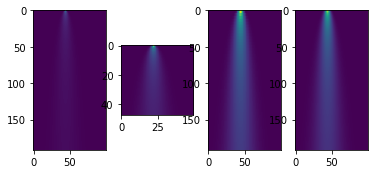

 13%|█████████████▉                                                                                            | 1310/10000 [03:03<17:50,  8.12it/s]

save
epoch: 1310/10000: train loss:1.3885477781295776,valid_loss:1.3889098167419434


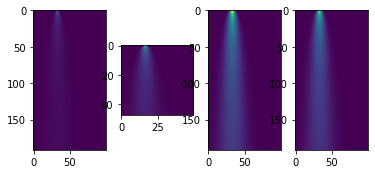

 13%|█████████████▉                                                                                            | 1320/10000 [03:04<17:41,  8.18it/s]

save
epoch: 1320/10000: train loss:1.3883078694343567,valid_loss:1.3889000415802002


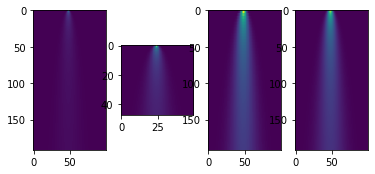

 13%|██████████████                                                                                            | 1330/10000 [03:06<17:02,  8.48it/s]

save
epoch: 1330/10000: train loss:1.3881406784057617,valid_loss:1.3888908624649048


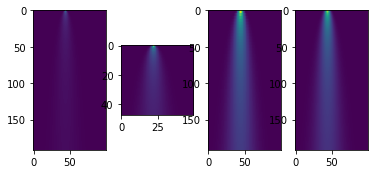

 13%|██████████████▏                                                                                           | 1340/10000 [03:08<19:59,  7.22it/s]

save
epoch: 1340/10000: train loss:1.3886544704437256,valid_loss:1.3888829946517944


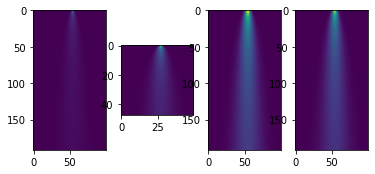

 14%|██████████████▎                                                                                           | 1350/10000 [03:09<18:15,  7.90it/s]

save
epoch: 1350/10000: train loss:1.388405203819275,valid_loss:1.3888763189315796


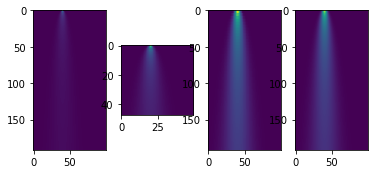

 14%|██████████████▍                                                                                           | 1360/10000 [03:10<17:26,  8.25it/s]

save
epoch: 1360/10000: train loss:1.3881616592407227,valid_loss:1.3888702392578125


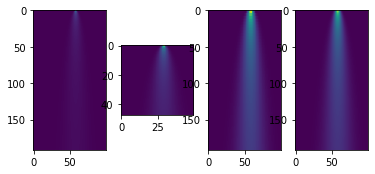

 14%|██████████████▌                                                                                           | 1370/10000 [03:12<16:38,  8.64it/s]

save
epoch: 1370/10000: train loss:1.3883538842201233,valid_loss:1.388864278793335


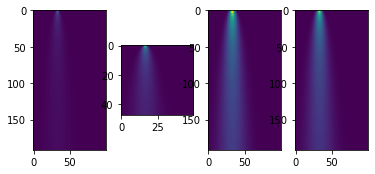

 14%|██████████████▋                                                                                           | 1380/10000 [03:13<16:21,  8.78it/s]

save
epoch: 1380/10000: train loss:1.3883109092712402,valid_loss:1.3888593912124634


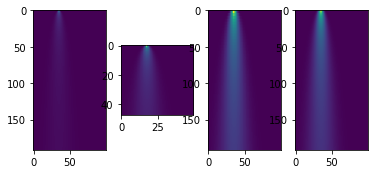

 14%|██████████████▋                                                                                           | 1390/10000 [03:14<18:01,  7.96it/s]

save
epoch: 1390/10000: train loss:1.3881893157958984,valid_loss:1.388855218887329


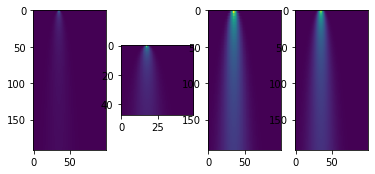

 14%|██████████████▊                                                                                           | 1400/10000 [03:16<16:55,  8.47it/s]

save
epoch: 1400/10000: train loss:1.3881456851959229,valid_loss:1.388851523399353


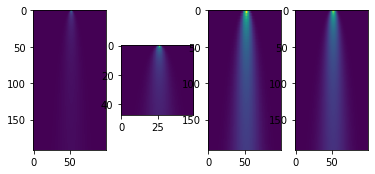

 14%|██████████████▉                                                                                           | 1410/10000 [03:17<13:38, 10.50it/s]

save
epoch: 1410/10000: train loss:1.3882287740707397,valid_loss:1.3888484239578247


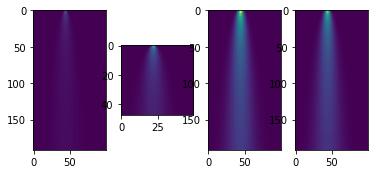

 14%|███████████████                                                                                           | 1420/10000 [03:18<12:52, 11.11it/s]

save
epoch: 1420/10000: train loss:1.3886789083480835,valid_loss:1.3888455629348755


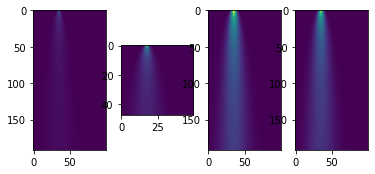

 14%|███████████████▏                                                                                          | 1430/10000 [03:19<12:51, 11.11it/s]

save
epoch: 1430/10000: train loss:1.3885045647621155,valid_loss:1.3888429403305054


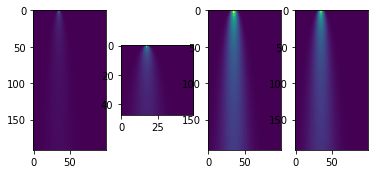

 14%|███████████████▎                                                                                          | 1440/10000 [03:20<12:37, 11.29it/s]

save
epoch: 1440/10000: train loss:1.3884865641593933,valid_loss:1.3888410329818726


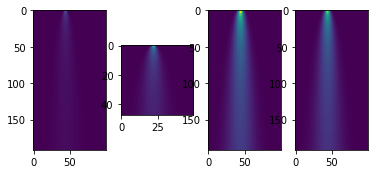

 14%|███████████████▎                                                                                          | 1450/10000 [03:21<12:51, 11.08it/s]

save
epoch: 1450/10000: train loss:1.3886303901672363,valid_loss:1.388838529586792


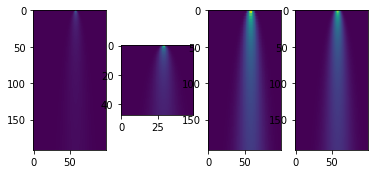

 15%|███████████████▍                                                                                          | 1460/10000 [03:22<12:35, 11.30it/s]

save
epoch: 1460/10000: train loss:1.3881989121437073,valid_loss:1.3888367414474487


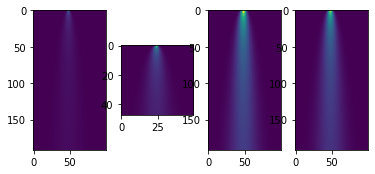

 15%|███████████████▌                                                                                          | 1470/10000 [03:23<12:31, 11.35it/s]

save
epoch: 1470/10000: train loss:1.3881884813308716,valid_loss:1.3888351917266846


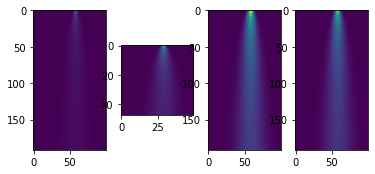

 15%|███████████████▋                                                                                          | 1480/10000 [03:24<12:39, 11.22it/s]

save
epoch: 1480/10000: train loss:1.3883573412895203,valid_loss:1.3888336420059204


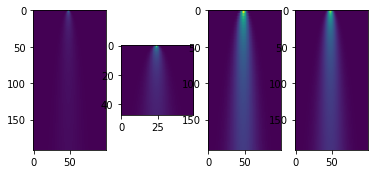

 15%|███████████████▊                                                                                          | 1490/10000 [03:25<12:30, 11.34it/s]

save
epoch: 1490/10000: train loss:1.3881449103355408,valid_loss:1.3888320922851562


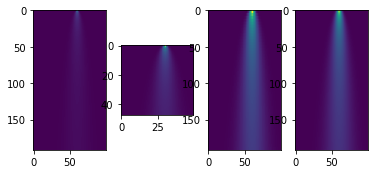

 15%|███████████████▉                                                                                          | 1500/10000 [03:26<12:27, 11.37it/s]

save
epoch: 1500/10000: train loss:1.388310432434082,valid_loss:1.3888307809829712


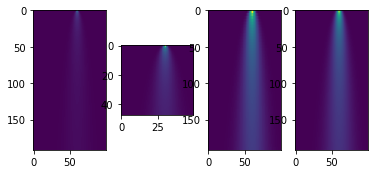

 15%|████████████████                                                                                          | 1510/10000 [03:27<12:29, 11.33it/s]

save
epoch: 1510/10000: train loss:1.38827645778656,valid_loss:1.388830304145813


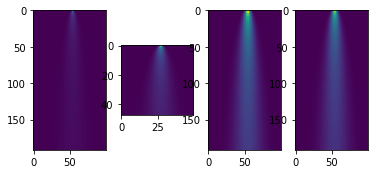

 15%|████████████████                                                                                          | 1520/10000 [03:28<12:40, 11.15it/s]

save
epoch: 1520/10000: train loss:1.3885627388954163,valid_loss:1.3888291120529175


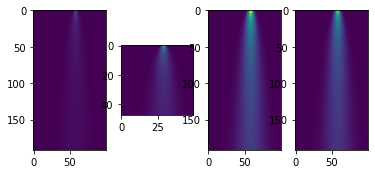

 15%|████████████████▏                                                                                         | 1530/10000 [03:29<12:24, 11.37it/s]

save
epoch: 1530/10000: train loss:1.3880223035812378,valid_loss:1.3888283967971802


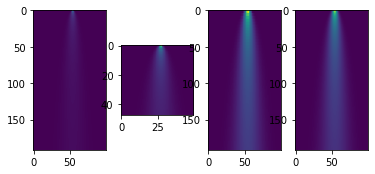

 15%|████████████████▎                                                                                         | 1540/10000 [03:30<12:23, 11.37it/s]

save
epoch: 1540/10000: train loss:1.3884986639022827,valid_loss:1.3888275623321533


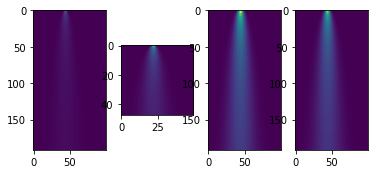

 16%|████████████████▍                                                                                         | 1550/10000 [03:31<12:23, 11.37it/s]

save
epoch: 1550/10000: train loss:1.3885209560394287,valid_loss:1.388826847076416


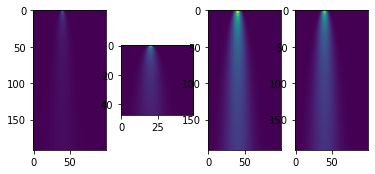

 16%|████████████████▌                                                                                         | 1560/10000 [03:32<12:26, 11.30it/s]

save
epoch: 1560/10000: train loss:1.3878778219223022,valid_loss:1.3888264894485474


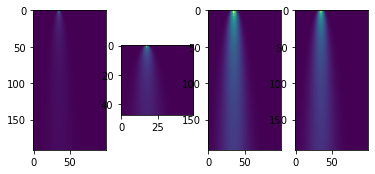

 16%|████████████████▋                                                                                         | 1570/10000 [03:33<12:36, 11.14it/s]

save
epoch: 1570/10000: train loss:1.3881497383117676,valid_loss:1.3888258934020996


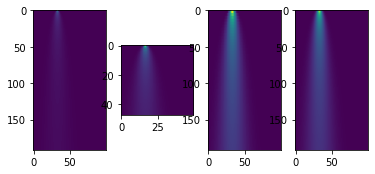

 16%|████████████████▋                                                                                         | 1580/10000 [03:34<12:44, 11.02it/s]

save
epoch: 1580/10000: train loss:1.3881677985191345,valid_loss:1.3888252973556519


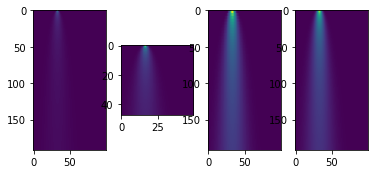

 16%|████████████████▊                                                                                         | 1590/10000 [03:36<20:23,  6.87it/s]

save
epoch: 1590/10000: train loss:1.388296127319336,valid_loss:1.3888251781463623


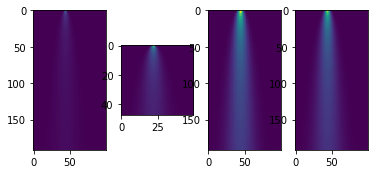

 16%|████████████████▉                                                                                         | 1600/10000 [03:37<13:10, 10.63it/s]

save
epoch: 1600/10000: train loss:1.388498067855835,valid_loss:1.388824224472046


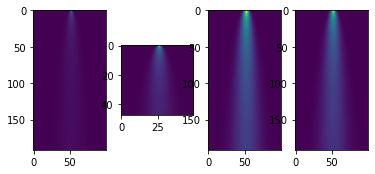

 16%|█████████████████                                                                                         | 1610/10000 [03:38<12:31, 11.16it/s]

epoch: 1610/10000: train loss:1.3880237340927124,valid_loss:1.388824462890625


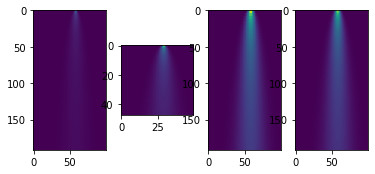

 16%|█████████████████▏                                                                                        | 1620/10000 [03:39<12:24, 11.25it/s]

save
epoch: 1620/10000: train loss:1.3885161876678467,valid_loss:1.3888239860534668


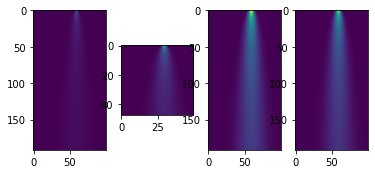

 16%|█████████████████▎                                                                                        | 1630/10000 [03:40<12:17, 11.36it/s]

save
epoch: 1630/10000: train loss:1.3885383009910583,valid_loss:1.3888238668441772


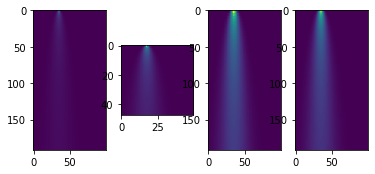

 16%|█████████████████▍                                                                                        | 1640/10000 [03:41<12:18, 11.31it/s]

save
epoch: 1640/10000: train loss:1.3883973956108093,valid_loss:1.3888237476348877


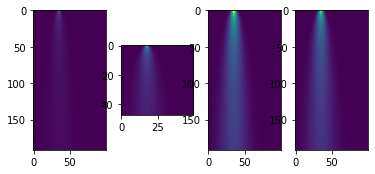

 16%|█████████████████▍                                                                                        | 1650/10000 [03:42<12:14, 11.38it/s]

save
epoch: 1650/10000: train loss:1.3886606097221375,valid_loss:1.3888232707977295


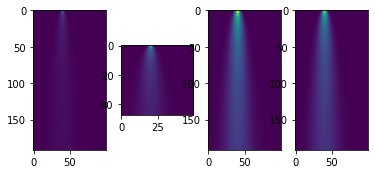

 17%|█████████████████▌                                                                                        | 1660/10000 [03:43<12:57, 10.73it/s]

epoch: 1660/10000: train loss:1.3884738087654114,valid_loss:1.3888232707977295


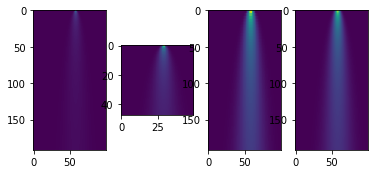

 17%|█████████████████▋                                                                                        | 1670/10000 [03:44<12:18, 11.27it/s]

epoch: 1670/10000: train loss:1.3883303999900818,valid_loss:1.3888232707977295


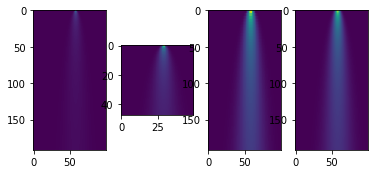

 17%|█████████████████▊                                                                                        | 1680/10000 [03:45<12:09, 11.41it/s]

save
epoch: 1680/10000: train loss:1.3882797956466675,valid_loss:1.38882315158844


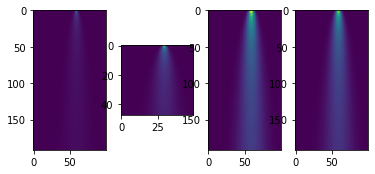

 17%|█████████████████▉                                                                                        | 1690/10000 [03:46<12:09, 11.39it/s]

save
epoch: 1690/10000: train loss:1.3882822394371033,valid_loss:1.3888227939605713


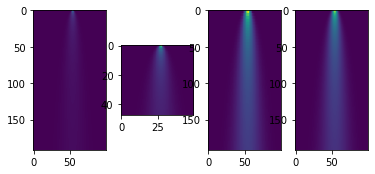

 17%|██████████████████                                                                                        | 1700/10000 [03:47<12:11, 11.34it/s]

epoch: 1700/10000: train loss:1.387885570526123,valid_loss:1.3888227939605713


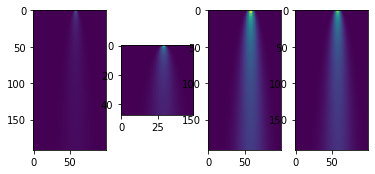

 17%|██████████████████▏                                                                                       | 1710/10000 [03:48<12:19, 11.21it/s]

save
epoch: 1710/10000: train loss:1.3885323405265808,valid_loss:1.3888225555419922


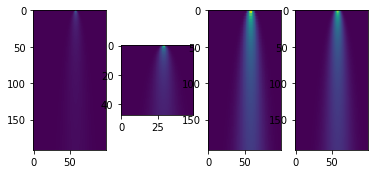

 17%|██████████████████▏                                                                                       | 1720/10000 [03:49<12:13, 11.29it/s]

save
epoch: 1720/10000: train loss:1.388038456439972,valid_loss:1.3888224363327026


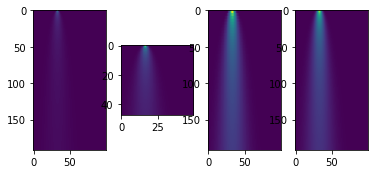

 17%|██████████████████▎                                                                                       | 1730/10000 [03:50<12:20, 11.17it/s]

epoch: 1730/10000: train loss:1.3881950974464417,valid_loss:1.3888226747512817


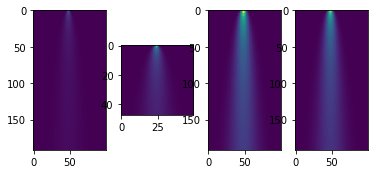

 17%|██████████████████▍                                                                                       | 1740/10000 [03:51<12:06, 11.36it/s]

epoch: 1740/10000: train loss:1.3882758617401123,valid_loss:1.3888225555419922


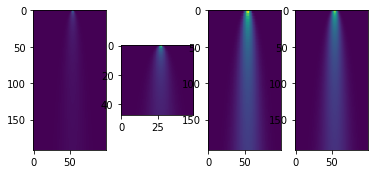

 18%|██████████████████▌                                                                                       | 1750/10000 [03:52<12:04, 11.39it/s]

save
epoch: 1750/10000: train loss:1.3885207772254944,valid_loss:1.388822317123413


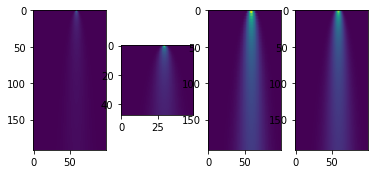

 18%|██████████████████▋                                                                                       | 1760/10000 [03:53<12:01, 11.42it/s]

save
epoch: 1760/10000: train loss:1.388461947441101,valid_loss:1.3888221979141235


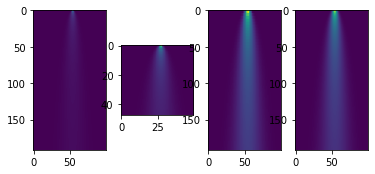

 18%|██████████████████▊                                                                                       | 1770/10000 [03:54<11:59, 11.44it/s]

epoch: 1770/10000: train loss:1.3885778188705444,valid_loss:1.3888221979141235


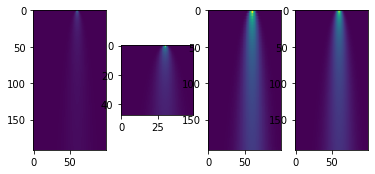

 18%|██████████████████▊                                                                                       | 1780/10000 [03:55<12:00, 11.40it/s]

epoch: 1780/10000: train loss:1.3883001804351807,valid_loss:1.3888221979141235


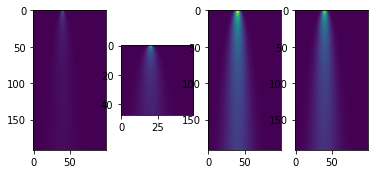

 18%|██████████████████▉                                                                                       | 1790/10000 [03:56<11:59, 11.41it/s]

epoch: 1790/10000: train loss:1.3883795738220215,valid_loss:1.3888221979141235


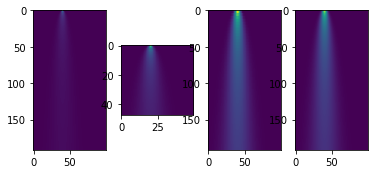

 18%|███████████████████                                                                                       | 1800/10000 [03:57<12:13, 11.18it/s]

epoch: 1800/10000: train loss:1.3885070085525513,valid_loss:1.388822317123413


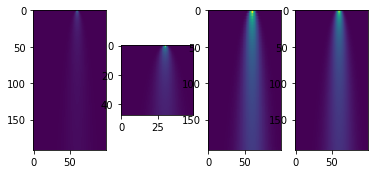

 18%|███████████████████▏                                                                                      | 1810/10000 [03:58<12:04, 11.31it/s]

save
epoch: 1810/10000: train loss:1.3883630633354187,valid_loss:1.3888219594955444


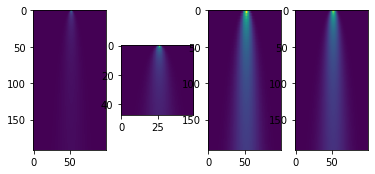

 18%|███████████████████▎                                                                                      | 1820/10000 [03:59<11:59, 11.37it/s]

epoch: 1820/10000: train loss:1.3883903622627258,valid_loss:1.3888219594955444


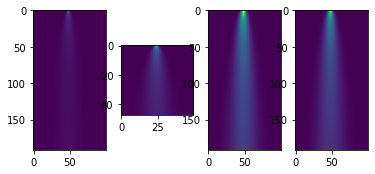

 18%|███████████████████▍                                                                                      | 1830/10000 [04:00<11:58, 11.37it/s]

epoch: 1830/10000: train loss:1.3886611461639404,valid_loss:1.3888219594955444


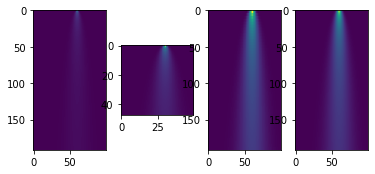

 18%|███████████████████▌                                                                                      | 1840/10000 [04:01<11:56, 11.39it/s]

epoch: 1840/10000: train loss:1.3883556127548218,valid_loss:1.388822078704834


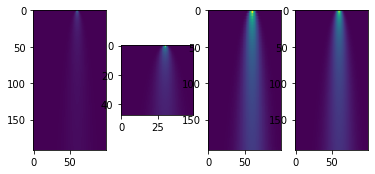

 18%|███████████████████▌                                                                                      | 1850/10000 [04:02<11:56, 11.37it/s]

epoch: 1850/10000: train loss:1.3882399797439575,valid_loss:1.3888219594955444


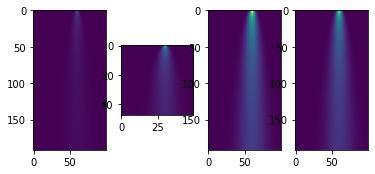

 19%|███████████████████▋                                                                                      | 1860/10000 [04:03<11:54, 11.40it/s]

save
epoch: 1860/10000: train loss:1.388501226902008,valid_loss:1.3888217210769653


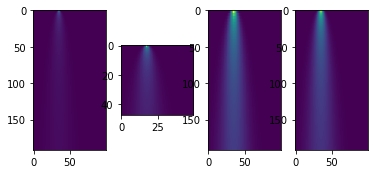

 19%|███████████████████▊                                                                                      | 1870/10000 [04:04<12:06, 11.19it/s]

epoch: 1870/10000: train loss:1.3881405591964722,valid_loss:1.3888219594955444


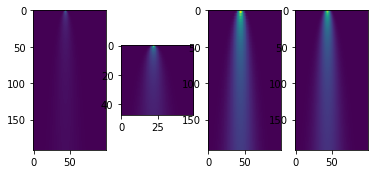

 19%|███████████████████▉                                                                                      | 1880/10000 [04:05<11:56, 11.34it/s]

save
epoch: 1880/10000: train loss:1.3884121179580688,valid_loss:1.3888214826583862


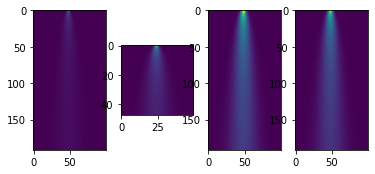

 19%|████████████████████                                                                                      | 1890/10000 [04:06<11:52, 11.38it/s]

epoch: 1890/10000: train loss:1.388472080230713,valid_loss:1.3888219594955444


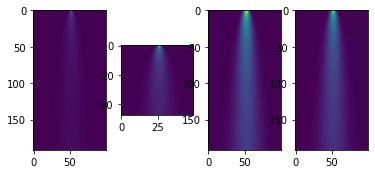

 19%|████████████████████▏                                                                                     | 1900/10000 [04:07<12:30, 10.80it/s]

epoch: 1900/10000: train loss:1.3883705735206604,valid_loss:1.3888214826583862


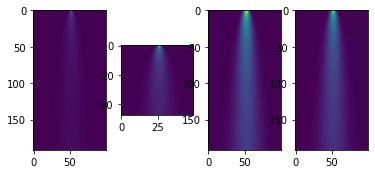

 19%|████████████████████▏                                                                                     | 1910/10000 [04:08<12:02, 11.20it/s]

epoch: 1910/10000: train loss:1.3885003328323364,valid_loss:1.3888217210769653


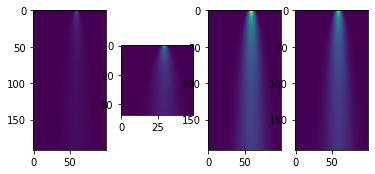

 19%|████████████████████▎                                                                                     | 1920/10000 [04:09<11:53, 11.32it/s]

save
epoch: 1920/10000: train loss:1.3881821036338806,valid_loss:1.3888213634490967


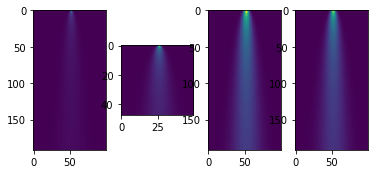

 19%|████████████████████▍                                                                                     | 1930/10000 [04:10<11:49, 11.37it/s]

save
epoch: 1930/10000: train loss:1.3882720470428467,valid_loss:1.3888211250305176


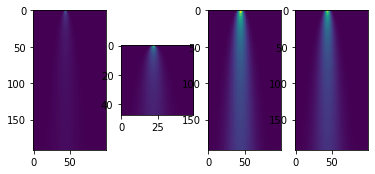

 19%|████████████████████▌                                                                                     | 1940/10000 [04:11<12:05, 11.11it/s]

epoch: 1940/10000: train loss:1.3884923458099365,valid_loss:1.3888213634490967


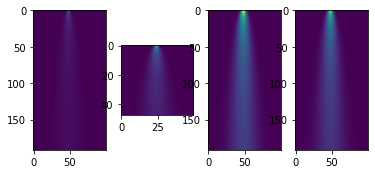

 20%|████████████████████▋                                                                                     | 1950/10000 [04:12<11:50, 11.32it/s]

epoch: 1950/10000: train loss:1.388648509979248,valid_loss:1.3888213634490967


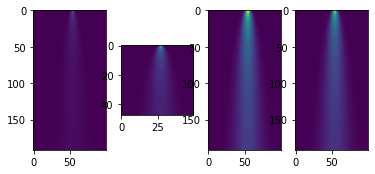

 20%|████████████████████▊                                                                                     | 1960/10000 [04:13<11:46, 11.38it/s]

epoch: 1960/10000: train loss:1.3880038857460022,valid_loss:1.3888213634490967


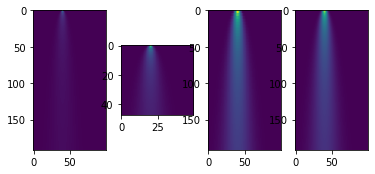

 20%|████████████████████▉                                                                                     | 1970/10000 [04:14<11:44, 11.39it/s]

epoch: 1970/10000: train loss:1.3881356120109558,valid_loss:1.3888217210769653


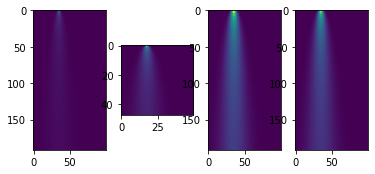

 20%|████████████████████▉                                                                                     | 1980/10000 [04:15<11:45, 11.37it/s]

epoch: 1980/10000: train loss:1.38829505443573,valid_loss:1.3888213634490967


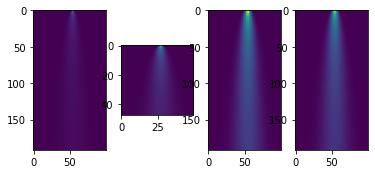

 20%|█████████████████████                                                                                     | 1990/10000 [04:16<11:48, 11.30it/s]

epoch: 1990/10000: train loss:1.3882341384887695,valid_loss:1.3888212442398071


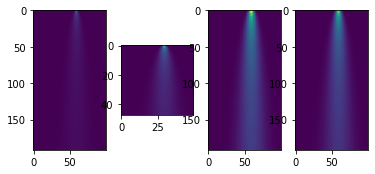

 20%|█████████████████████▏                                                                                    | 2000/10000 [04:17<11:42, 11.39it/s]

epoch: 2000/10000: train loss:1.3882697224617004,valid_loss:1.3888212442398071


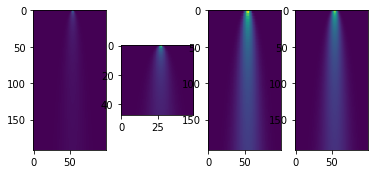

 20%|█████████████████████▎                                                                                    | 2010/10000 [04:18<11:59, 11.10it/s]

epoch: 2010/10000: train loss:1.3884849548339844,valid_loss:1.3888214826583862


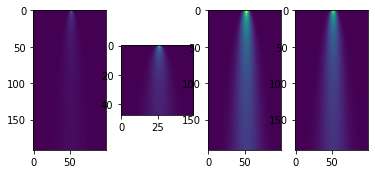

 20%|█████████████████████▍                                                                                    | 2020/10000 [04:19<11:49, 11.24it/s]

epoch: 2020/10000: train loss:1.3883308172225952,valid_loss:1.3888213634490967


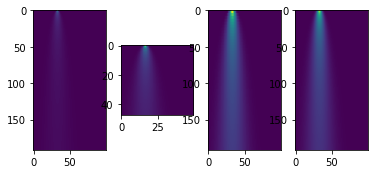

 20%|█████████████████████▌                                                                                    | 2030/10000 [04:20<11:41, 11.36it/s]

epoch: 2030/10000: train loss:1.3885048627853394,valid_loss:1.3888213634490967


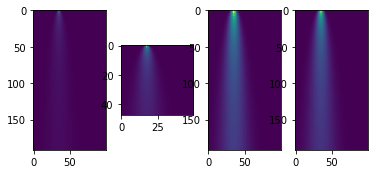

 20%|█████████████████████▌                                                                                    | 2040/10000 [04:21<17:00,  7.80it/s]


In [102]:
'coarse graining training...'
loss_kl = torch.nn.KLDivLoss(reduction='batchmean')
num_epochs = 10000

torch.manual_seed(seed)
random.seed(seed)
model = TemporalSpatialConv(tgroup=tgroup, sgroup=sgroup)
model = model.cuda() if use_cuda else model
optimizer2 = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
last_valid_loss = 10000
count = 0
train_losses2 = []
valid_losses2 = []
for epoch in tqdm(range(num_epochs)):
    loss_t2 = []
    loss_v2 = []
    model.train()
    for train_x,train_y in train_loader:
        if use_cuda:
            train_x = train_x.cuda()
            train_y = train_y.cuda()
        encoder = model.Encoder(train_x)
        b,t,l = encoder.shape
        macro_pred = dynamic(encoder.reshape(-1,l)).reshape(b,t,l)
        decoder = model.Decoder(macro_pred)
        b,t,l = decoder.shape
        loss = loss_kl(torch.log(decoder.reshape(-1,l)+NEAR_ZERO),train_y.reshape(-1,l)+NEAR_ZERO)
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        loss_t2.append(loss.item())
    train_losses2.append(np.mean(loss_t2))

    if epoch % 10 == 0:
        model.eval()
        for valid_x,valid_y in valid_loader:
            if use_cuda:
                valid_x = valid_x.cuda()
                valid_y = valid_y.cuda()
            encoder = model.Encoder(valid_x)
            b,t,l = encoder.shape
            macro_pred = dynamic(encoder.reshape(-1,l)).reshape(b,t,l)
            b,t,l = decoder.shape
            decoder = model.Decoder(macro_pred)
            loss = loss_kl(torch.log(decoder.reshape(-1,l)+NEAR_ZERO),valid_y.reshape(-1,l)+NEAR_ZERO)
            loss_v2.append(loss.item())
        valid_losses2.append(np.mean(loss_v2))

        if np.mean(loss_v2) > last_valid_loss:
            count += 1
            if count > 10:
                break
        if np.mean(loss_v2) < last_valid_loss:
            count = 0
            print('save')
            torch.save(model,f'./models/encoder/diffusion_encoder_sgroup={sgroup}_tgroup={tgroup}_{seed}_k={kernel_size}.pth')
            last_valid_loss = np.mean(loss_v2)

        print(f'epoch: {epoch}/{num_epochs}: train loss:{np.mean(loss_t2)},valid_loss:{np.mean(loss_v2)}')
        plt.subplot(141)
        plt.imshow(valid_x[0])
        plt.subplot(142)
        plt.imshow(encoder[0].detach())
        plt.subplot(143)
        plt.imshow(decoder[0].detach())
        plt.subplot(144)
        plt.imshow(valid_y[0].detach())
        plt.show()


In [103]:
# torch.save(model,f'./models/diffusion_encoder_sgroup={sgroup}_tgroup={tgroup}.pth.pth')

In [104]:
kernel_size

5

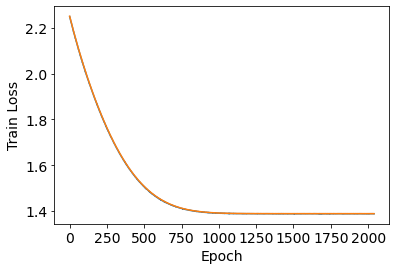

In [105]:
plt.plot(train_losses2)
plt.plot(np.arange(0,len(train_losses2),10),valid_losses2)
# plt.yscale('log')
plt.ylabel('Train Loss',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()
with open(f'./data/loss_self_{kernel_size}_{seed}.pkl','wb') as f:
    pkl.dump({
        'train':train_losses2,
        'valid':valid_losses2
    },f)

In [51]:
'generate test data'
'1d'
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
seed = 2050
np.random.seed(seed)
    
# 参数设置
T = 198 # 总时间
dt = 1  # 时间步长
steps = int(T/dt)
space = np.arange(0,98,1)
D =0.5
L = len(space)
pt = np.zeros([steps,L])
center = 40
print(center, L)
pt[0,center] = 1
for step in range(steps-1):
    step = step+1
    pt[step,:] = 1/(np.sqrt(4*np.pi*D*step)) * np.exp(-(space-center)**2/(4*D*step))


40 98


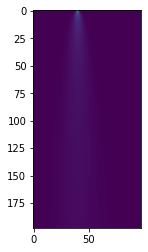

In [52]:
plt.imshow(pt)

In [53]:
pt = torch.tensor(pt,dtype=torch.float)
pt.shape

torch.Size([198, 98])

In [54]:
seed = 2051
sgroup = 2
tgroup = 4
model = torch.load(f'./models/encoder/diffusion_encoder_sgroup={sgroup}_tgroup={tgroup}_{seed}_k=7.pth')

In [55]:
'single step 预测'
pred = dynamic(pt)

In [56]:
print('1 step MAE: ',torch.mean(abs(pred[:-1,:].detach()-pt[1:,:].detach())))

1 step MAE:  tensor(3.8222e-05)


In [57]:
'multi step'
pred_steps = 198
pred = torch.zeros(pred_steps,L)
pred[0:1,:] = dynamic(pt[0:1,:])
for step in range(pred_steps):
    pred[step+1:step+2,:] = dynamic(pred[step:step+1,:])


In [59]:
'encoder + dynamic + decoder'
encoder = model.Encoder(pt.unsqueeze(0))
print(pt.shape,encoder.shape)
macro_preds = dynamic(encoder[0,:,:])
print(macro_preds.shape)
decoder = model.Decoder(macro_preds.unsqueeze(0))
print(decoder.shape)
'decoder mae'
print('MAE: ',torch.mean(abs(decoder[0,:,:].detach()-pt[2:,:])))

torch.Size([198, 98]) torch.Size([1, 49, 49])
torch.Size([49, 49])
torch.Size([1, 196, 98])
MAE:  tensor(0.0077)


In [60]:
from utils import *
import seaborn as sns

fontsize=14

In [61]:
colors = sns.color_palette('GnBu_r',10)

In [62]:
'single单步粗粒化'
encoder = model.Encoder(pt.unsqueeze(0))
print(pt.shape,encoder.shape)
macro_preds = dynamic(encoder[0,:,:])
macro_preds.shape

torch.Size([198, 98]) torch.Size([1, 49, 49])


torch.Size([49, 49])

In [63]:
print('MAE: ',torch.mean(abs(macro_preds[:-1,:].detach()-encoder[0,1:,:].detach())))

MAE:  tensor(0.0002)


In [64]:
encoder = model.Encoder(pt.unsqueeze(0))
print(encoder.shape)
pred_steps = 100
macro_preds = torch.zeros(encoder.shape)[0,:,:]
b,t,l = encoder.shape
macro_preds[0:1,:] = dynamic(encoder[:,0:1,:].reshape(-1,l)).reshape(1,l)
for step in range(pred_steps):
    macro_preds[step+1:step+2] = dynamic(macro_preds[step:step+1,:])
encoder.shape,macro_preds.shape

torch.Size([1, 49, 49])


(torch.Size([1, 49, 49]), torch.Size([49, 49]))

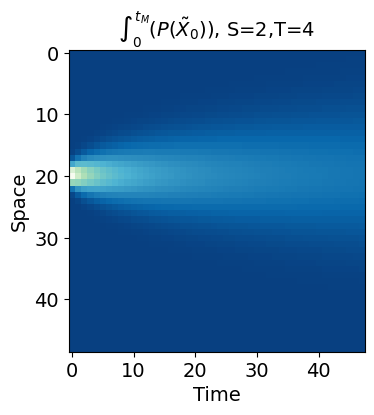

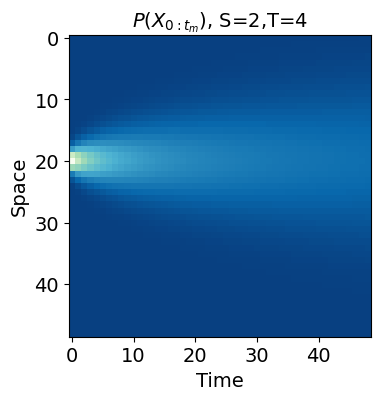

In [65]:
plt.figure(dpi=100)
# plt.subplot(121)
plt.imshow(encoder[0,1:,:].detach().T,cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize)
plt.title(r'$\int_0^{t_M}(P (\tilde{X}_0))$'+f', S={sgroup},T={tgroup}',fontsize=fontsize)
# plt.show()
plt.figure(dpi=100)
plt.imshow(macro_preds.detach().T,cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize)
plt.title(r"$P ({X}_{0:t_m})$"+f', S={sgroup},T={tgroup}',fontsize=fontsize)
plt.show()

In [66]:
macro_preds.shape, encoder.shape

(torch.Size([49, 49]), torch.Size([1, 49, 49]))

In [67]:
print('粗粒化 MAE: ',torch.mean(abs(macro_preds[:-1,:].detach()-encoder[0,1:,:].detach())))

粗粒化 MAE:  tensor(0.0025)


In [68]:
colors = sns.color_palette('GnBu_r',10)
colors

[(0.03137254901960784, 0.36416762783544787, 0.6275586312956556),
 (0.09219530949634756, 0.47040369088811995, 0.7057900807381776),
 (0.19123414071510958, 0.5742099192618224, 0.7586620530565167),
 (0.29457900807381776, 0.6893656286043829, 0.8206689734717416),
 (0.4186851211072664, 0.7646289888504422, 0.7898500576701268),
 (0.5460207612456748, 0.8240522875816993, 0.7474048442906575),
 (0.6704498269896194, 0.8711880046136101, 0.7149711649365629),
 (0.7767474048442907, 0.9125259515570934, 0.7622145328719724),
 (0.8436755094194541, 0.939038831218762, 0.8205920799692425),
 (0.9035447904652056, 0.9627681660899654, 0.881753171856978)]

In [69]:
def get_distance_VS_t(data):
    b,steps,L = data.shape
    center = L // 2
    msds = np.zeros([b,steps])
#     print(msds.shape)
    for b in range(data.shape[0]):
        msds[b,:] = np.array([np.sum((abs(np.where(data[b,i,:]!= 0)[0]-center)**2)*data[b,i, np.where(data[b,i,:]!= 0)[0]]) for i in range(data.shape[1])])
#     print(msds.shape)
    return steps,msds

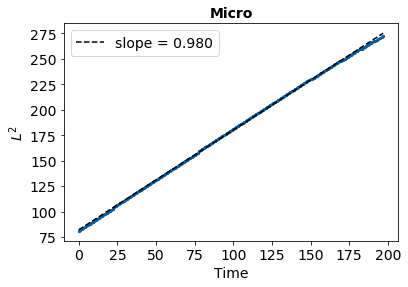

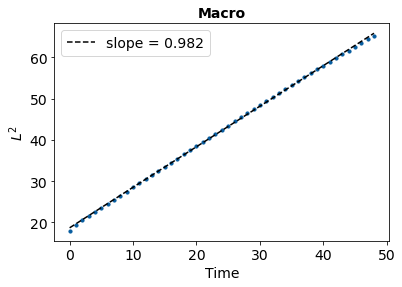

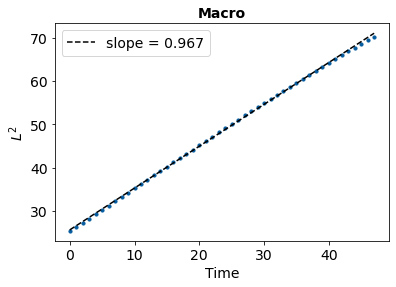

In [70]:
# plt.subplot(211)
steps,msds = get_distance_VS_t(np.array(pt.unsqueeze(0)))
yy = np.mean(msds,axis=0)
plt.scatter(range(steps), yy,s=1)

slope, intercept, r_value, p_value, std_err = linregress(range(steps), yy[:steps])
plt.scatter(range(steps), yy[:steps],color=colors[0],s=5)
plt.plot(range(steps), range(steps) * slope + intercept, '--',color='k',label=f'slope = {slope:.3f}')
#     if idx == 0:
set_plot_basicinf(r'$L^2$','Time',fontsize)
plt.title('Micro',fontsize=fontsize,fontweight='bold')
plt.legend(fontsize=fontsize,loc=2)
plt.show()


# plt.subplot(212)
steps,msds = get_distance_VS_t(np.array(encoder.detach()))
yy = np.mean(msds,axis=0)
plt.scatter(range(steps), yy,s=1)

slope, intercept, r_value, p_value, std_err = linregress(range(steps), yy[:steps])
plt.scatter(range(steps), yy[:steps],color=colors[0],s=10)
plt.plot(range(steps), range(steps) * slope + intercept, '--',color='k',label=f'slope = {slope:.3f}')
plt.title('Macro',fontsize=fontsize,fontweight='bold')
plt.legend(fontsize=fontsize)
set_plot_basicinf(r'$L^2$','Time',fontsize)
plt.show()


steps,msds = get_distance_VS_t(np.array(macro_pred.detach()))
yy = np.mean(msds,axis=0)
plt.scatter(range(steps), yy,s=1)

slope, intercept, r_value, p_value, std_err = linregress(range(steps), yy[:steps])
plt.scatter(range(steps), yy[:steps],color=colors[0],s=10)
plt.plot(range(steps), range(steps) * slope + intercept, '--',color='k',label=f'slope = {slope:.3f}')
plt.title('Macro',fontsize=fontsize,fontweight='bold')
set_plot_basicinf(r'$L^2$','Time',fontsize)
plt.legend(fontsize=fontsize)
plt.show()